In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib import rc
from datetime import datetime
import re
import nltk
from os import path
from PIL import Image
import numpy as np
import squarify

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import operator

In [14]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import coo_matrix

In [3]:
rc(
    "font",
    **{
        "family": "sans-serif",
        "sans-serif": ["Helvetica"],
        "monospace": ["Inconsolata"],
        "serif": ["Baskerville"],
    }
)

rc("text", **{"usetex": True})
rc("text", **{"latex.preamble": "\\usepackage{sfmath}"})
rc("hatch", **{"linewidth": 0.45})



In [4]:
%matplotlib inline

# plot constants
dotsize = 2.
linewidth = .5
fontsize = 12

In [9]:
df = pd.read_pickle("participation_zotero.pickle")
df.head()

,title,creator,date,abstract,doi,publication,date_added
0,Stakeholder involvement in climate assessment:...,O'Connor et al.,2000-01-01,Stakeholder participation is a crucial compone...,10.3354/cr014255,Climate Research,2019-06-05 12:17:51+00:00
1,Children with disabilities: A longitudinal stu...,Hauser-Cram et al.,2001-01-01,The development of children with disabilities ...,10.1111/1540-5834.00151,Monographs of the Society for Research in Chil...,2019-06-05 12:17:51+00:00
3,Fair adaptation to climate change,Paavola and Adger,2006-01-01,This article identifies social justice dilemma...,10.1016/j.ecolecon.2005.03.015,Ecological Economics,2019-06-05 12:17:51+00:00
4,Institutional adaptation of water resource inf...,Crabbe and Robin,2006-01-01,Institutional barriers and bridges to local cl...,10.1007/s10584-006-9087-5,Climatic Change,2019-06-05 12:17:51+00:00
6,Community capacity for adaptation to climate-i...,Ivey et al.,2004-01-01,There is growing concern for the capacity of u...,10.1007/s00267-003-0014-5,Environmental Management,2019-06-05 12:17:51+00:00


In [38]:
# read original corpus
df_b = pd.read_pickle("CCA_processed.pickle")

In [40]:
df_b.head()

,title,date,abstract,word_count,abstract_clean
0,Adaptation to Coastal Storms in Atlantic Canad...,2018-01-01,In order to improve the resilience of social-e...,162,order improve resilience social ecological sys...
1,Adaptation to Coastal Storms in Atlantic Canad...,2018-01-01,"In this chapter, we describe the methodologica...",123,chapter describe methodological approach selec...
2,"A regional, multi-sectoral and integrated asse...",2005-01-01,The 'Regional Climate Change Impact and Respon...,198,regional impact response study east anglia nor...
3,Bridging the gap: empowering decision-making f...,2006-01-01,"The methods, tools and outputs of the UK Clima...",231,method tool output uk impact programme ukcip b...
4,The Value of Linking Mitigation and Adaptation...,2009-01-01,There are two principal strategies for managin...,254,principal strategy managing risk mitigation re...


In [41]:
df.head()

,title,creator,date,abstract,doi,publication,date_added,abstract_clean
0,Stakeholder involvement in climate assessment:...,O'Connor et al.,2000-01-01,Stakeholder participation is a crucial compone...,10.3354/cr014255,Climate Research,2019-06-05 12:17:51+00:00,stakeholder participation crucial component mi...
1,Children with disabilities: A longitudinal stu...,Hauser-Cram et al.,2001-01-01,The development of children with disabilities ...,10.1111/1540-5834.00151,Monographs of the Society for Research in Chil...,2019-06-05 12:17:51+00:00,development child disability family present ar...
3,Fair adaptation to climate change,Paavola and Adger,2006-01-01,This article identifies social justice dilemma...,10.1016/j.ecolecon.2005.03.015,Ecological Economics,2019-06-05 12:17:51+00:00,identifies social justice dilemma associated n...
4,Institutional adaptation of water resource inf...,Crabbe and Robin,2006-01-01,Institutional barriers and bridges to local cl...,10.1007/s10584-006-9087-5,Climatic Change,2019-06-05 12:17:51+00:00,institutional barrier bridge local impact affe...
6,Community capacity for adaptation to climate-i...,Ivey et al.,2004-01-01,There is growing concern for the capacity of u...,10.1007/s00267-003-0014-5,Environmental Management,2019-06-05 12:17:51+00:00,growing concern capacity urban rural community...


In [78]:
len(df_b)

258

In [86]:
combined = pd.concat([df, df_b], sort=False, ignore_index=True)

In [87]:
len(combined)

486

In [7]:
def cleanup(txt, stop_words):
    """ Clean up abstract text for statistics """
    text = re.sub("[^a-zA-Z]", " ", txt)
    # Convert to lowercase
    text = text.lower()
    # Remove tags
    text = re.sub("&lt;/?.*?&gt;", " &lt;&gt; ", text)
    # Remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    text = text.split()
    # Stemming
    ps = PorterStemmer()
    # Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words]
    text = " ".join(text)
    return text


def get_top_n_words(corpus, n=None):
    """ Most frequently occuring words """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n2_words(corpus, n=None):
    """ Most frequently occuring Bi-grams """
    vec1 = CountVectorizer(ngram_range=(2, 2), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n3_words(corpus, n=None):
    """ Most frequently occuring Tri-grams """
    vec1 = CountVectorizer(ngram_range=(3, 3), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


def sort_coo(coo_matrix):
    """ Sort co-occurrences """
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """ Get the feature names and tf-idf score of the top n items
    
    tf-idf (term frequency-inverse document frequency) is a numerical
    statistic that is intended to reflect how important a word
    is to a document in a collection or corpus.
    """

    # use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    # word index and corresponding tf-idf score
    for idx, score in sorted_items:

        # keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    # create a tuple of feature, score
    # results = zip(feature_vals,score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]

    return results


def custom_bars(series, cmap):
    """ Generate custom colour bars for matplotlib """
    data_colour = [x / max(series) for x in series]
    my_cmap = plt.cm.get_cmap(cmap)
    colours = my_cmap(data_colour)
    return colours



In [11]:
# earliest and latest date criteria
start_date = datetime(2000, 1, 1)
end_date = datetime(2018, 1, 1)
mask = (df["date"] >= start_date) & (df["date"] <= end_date)

<Figure size 432x288 with 0 Axes>

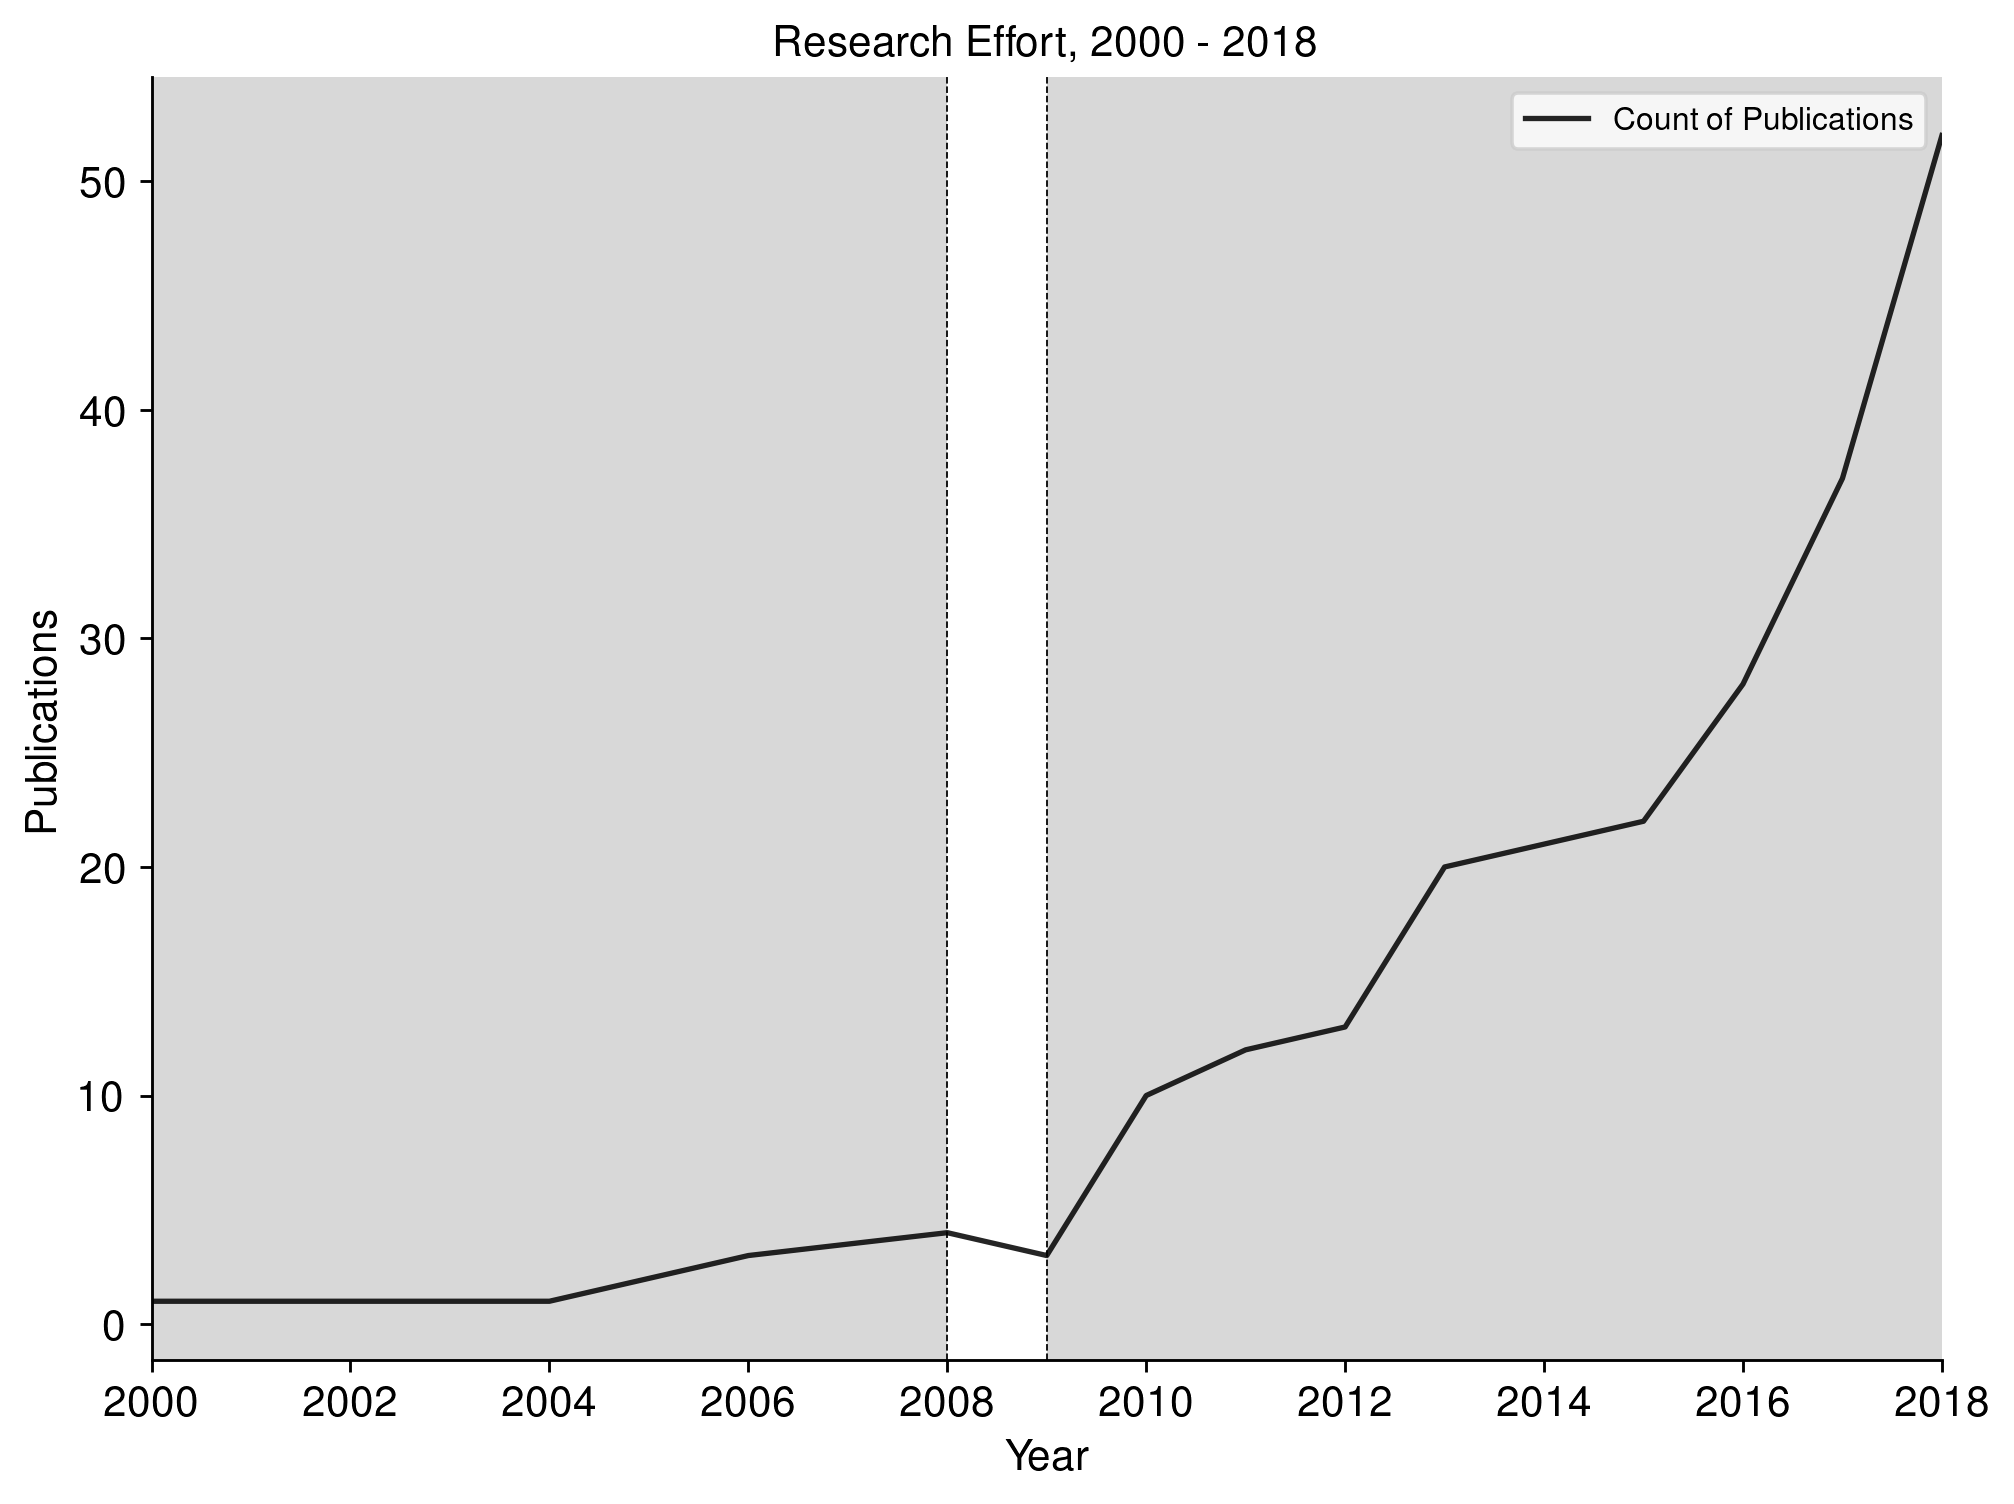

In [261]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
df.loc[mask].date.groupby(df.date.dt.year).agg({"count"}).plot(
    ax=ax,
    color="black",
    alpha=0.85,
    fontsize=fontsize,
)
lines = [2008, 2009]
for line in lines:
    plt.axvline(x=line, color="black", lw=0.5, linestyle="--")
plt.axvspan(2000, 2008, facecolor="grey", alpha=0.3)
plt.axvspan(2009, 2018, facecolor="grey", alpha=0.3)
# plt.axvspan(2017, 2018, facecolor="grey", alpha=0.3)
leg = ax.legend(["Count of Publications"], fontsize=9)
ax.set_ylabel("Publications", fontsize=fontsize)
plt.title("Research Effort, 2000 - 2018")
ax.set_xlabel("Year", fontsize=fontsize)
plt.tight_layout()
plt.savefig("participation_time.png", dpi=300)
# plt.savefig("time.eps", dpi=300)
plt.show()



In [15]:
# Create a list of stop words and add custom stopwords
stop_words = set(stopwords.words("english"))
# Create a list of custom stopwords
new_words = [
    "using",
    "show",
    "result",
    "large",
    "also",
    "iv",
    "one",
    "two",
    "new",
    "previously",
    "shown",
]
# these are the search keywords
new_words.extend(["climate", "change", "adaptation", "engagement", "public", "citizen"])
# these are metadata words, we definitely don't want these
new_words.extend(
    [
        "paper",
        "interest",
        "author",
        "declared",
        "conflict",
        "clim",
        "wire",
        "doi",
        "wcc",
        "ltd",
        "limited",
        "right",
        "reserved",
        "elsevier",
        "john",
        "wiley",
        "sons",
        "article",
        "please",
        "visit",
        "case",
        "study",
    ]
)
stop_words = stop_words.union(new_words)

df["abstract_clean"] = df.apply(lambda x: cleanup(x.abstract, stop_words), axis=1)



In [16]:
top_words = get_top_n_words(df.abstract_clean, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ["Word", "Freq"]

<Figure size 432x288 with 0 Axes>

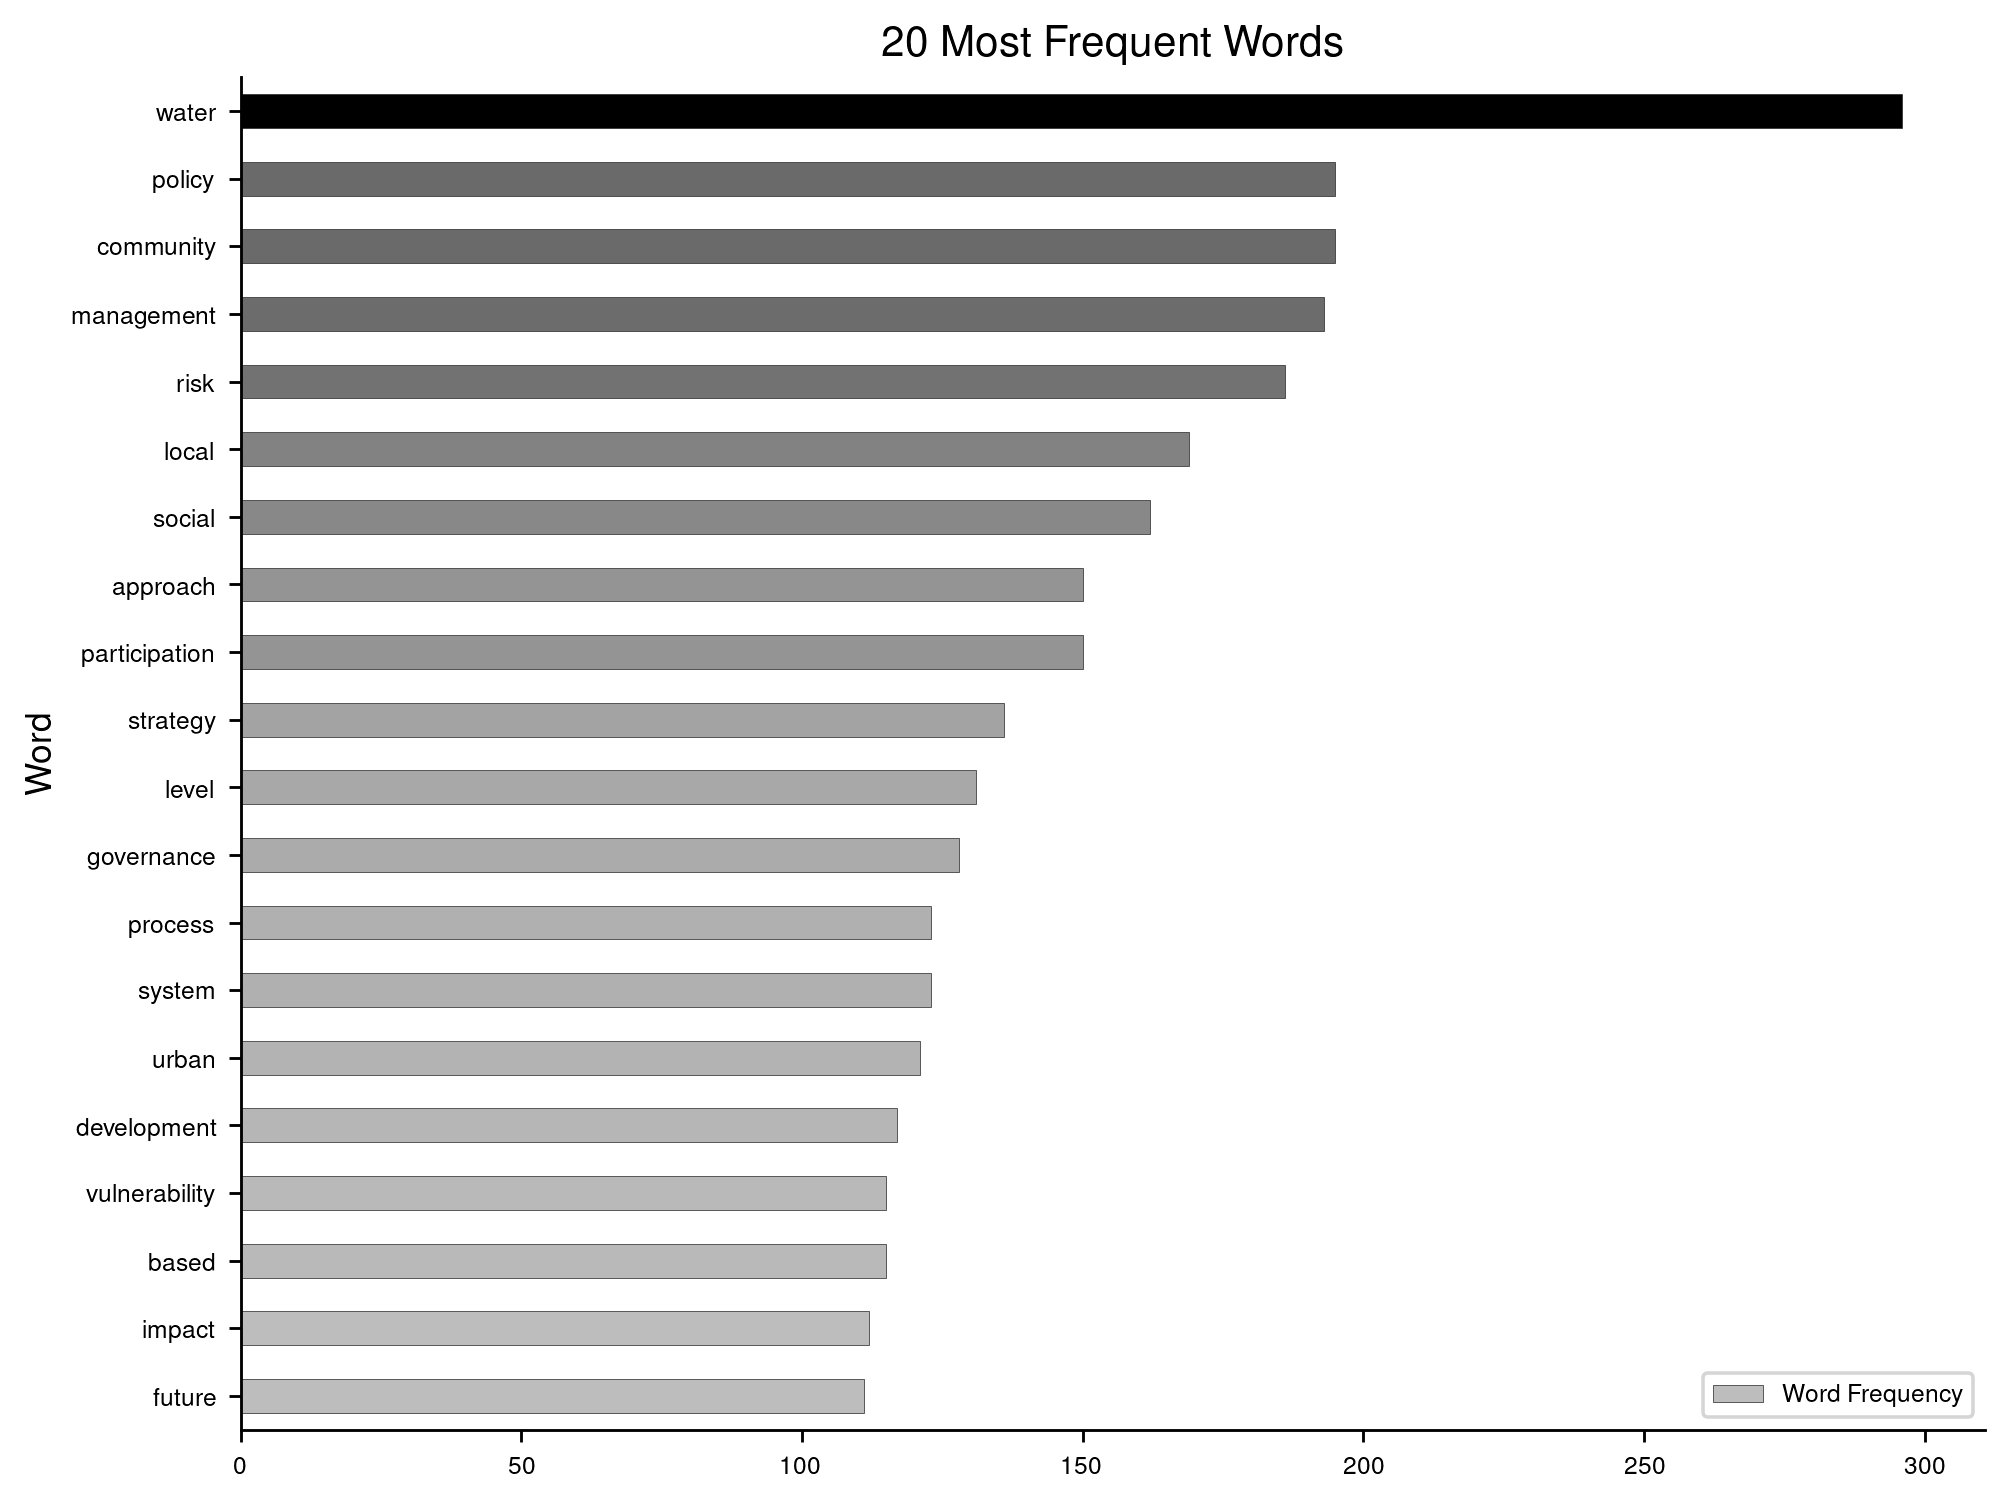

In [114]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

c = custom_bars(top_df.sort_values(by=["Freq"]).Freq, "Greys")

top_df.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Word", y="Freq", fontsize=7, color=c, edgecolor="#282828", lw=0.2
)
leg = ax.legend(["Word Frequency"], fontsize=7)
plt.title("20 Most Frequent Words")
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("participation_words_single.png", dpi=300)
plt.show()



In [18]:
top2_words = get_top_n2_words(df.abstract_clean, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ["Bigram", "Freq"]



<Figure size 432x288 with 0 Axes>

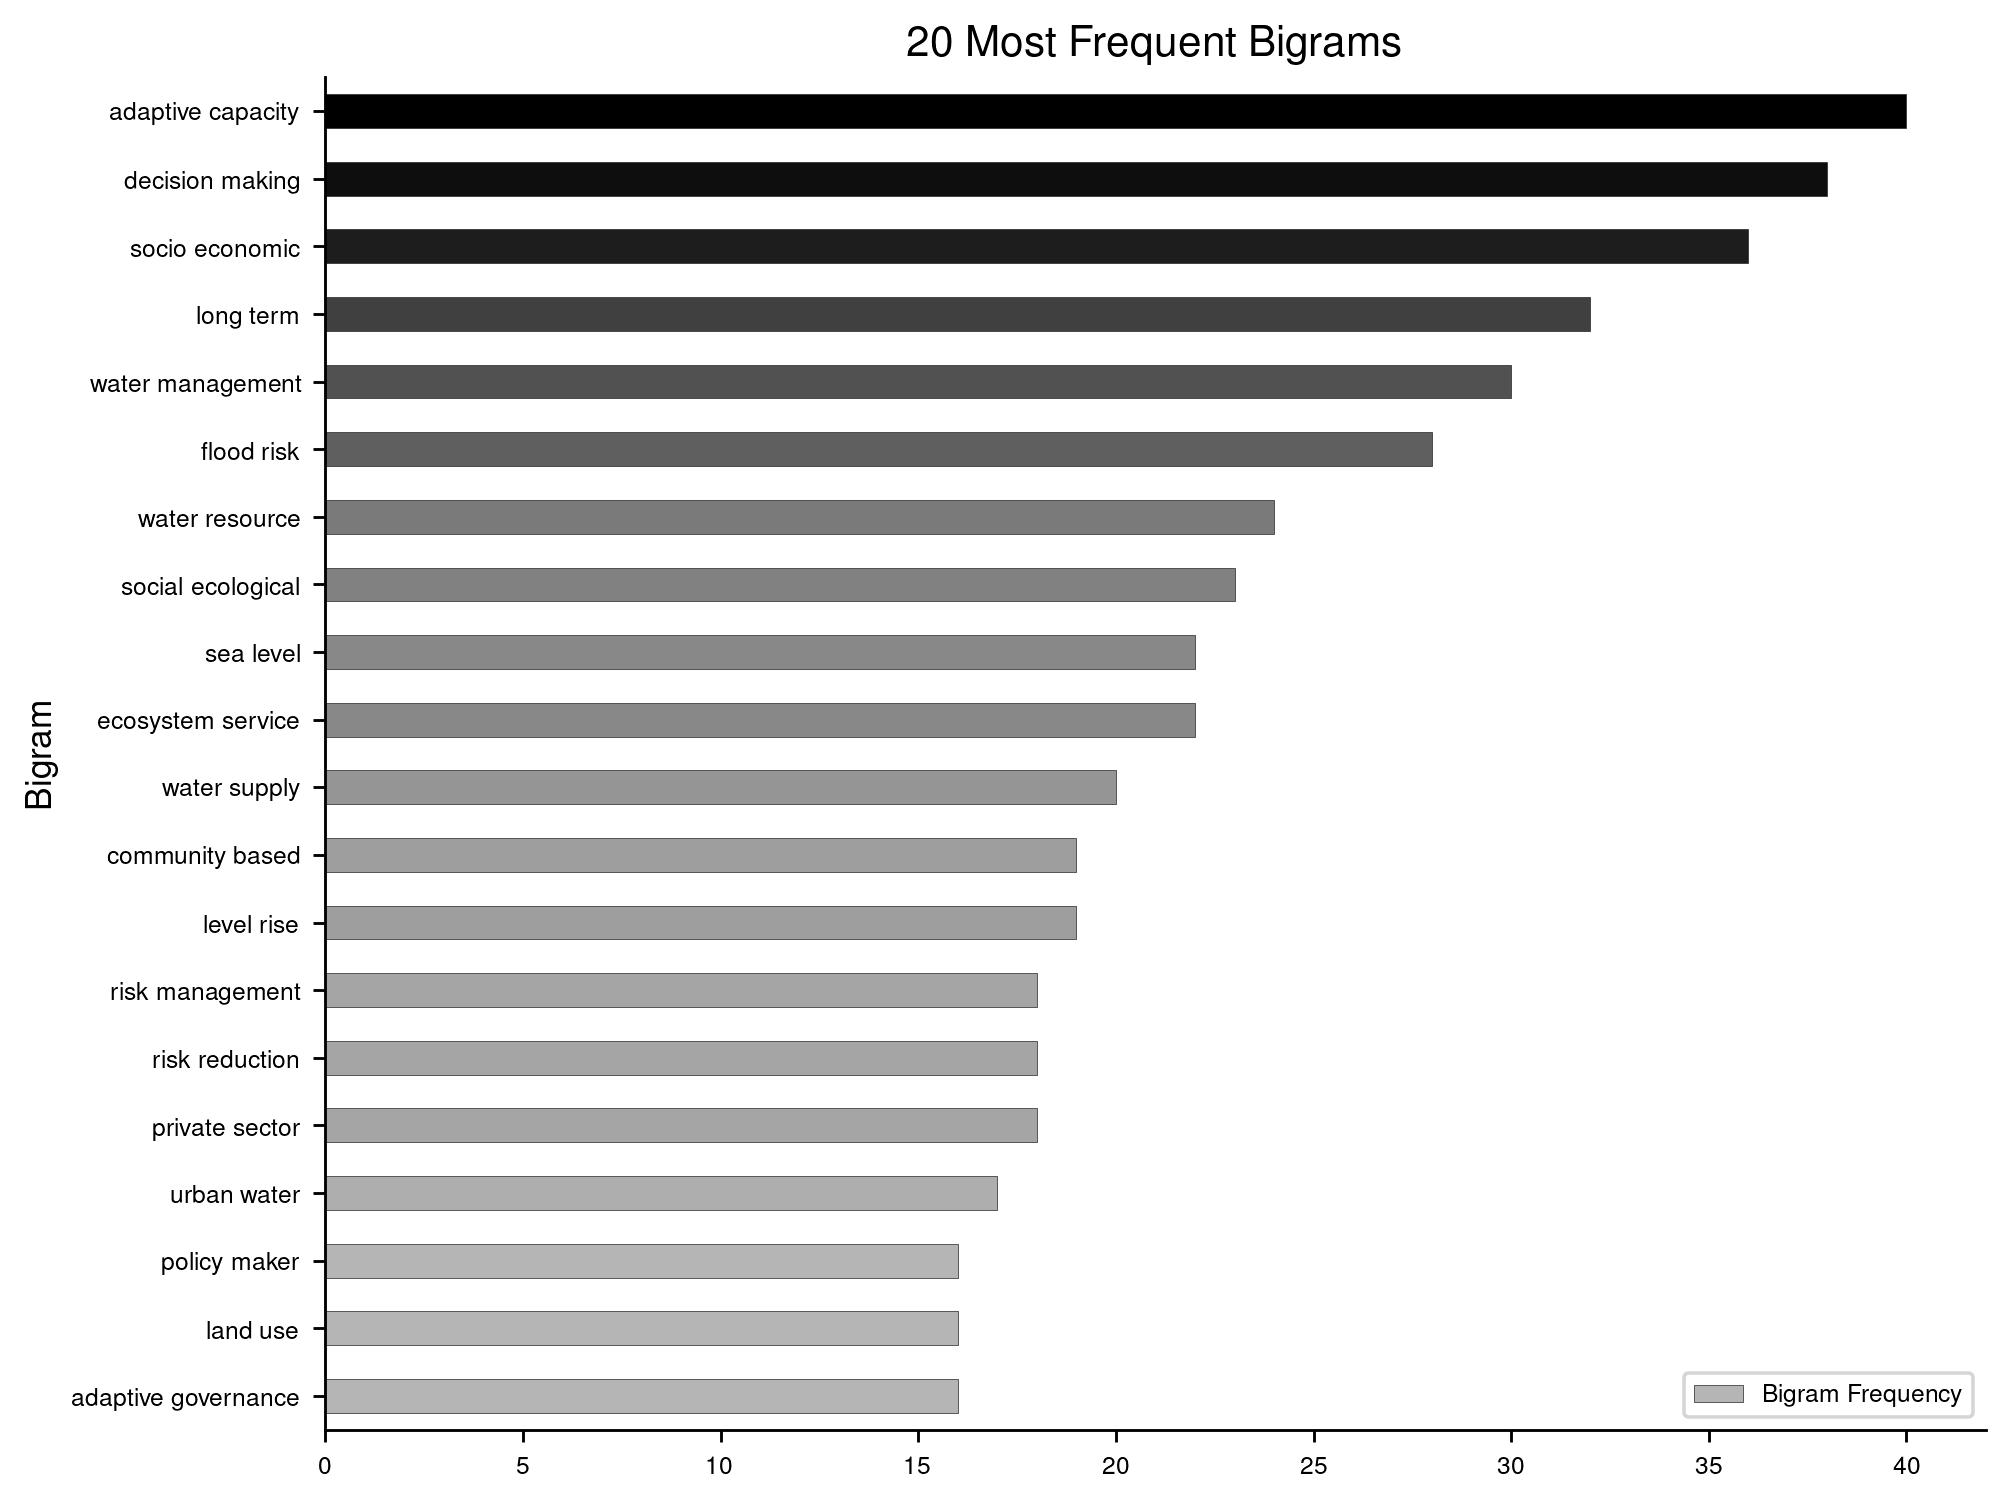

In [113]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

c = custom_bars(top2_df.sort_values(by=["Freq"]).Freq, "Greys")

top2_df.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Bigram", y="Freq", fontsize=7, color=c, edgecolor="#282828", lw=0.2
)
plt.title("20 Most Frequent Bigrams")
leg = ax.legend(["Bigram Frequency"], fontsize=7)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("participation_bigrams.png", dpi=300)
plt.show()


In [30]:
top3_words = get_top_n3_words(df.abstract_clean, n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns = ["Trigram", "Freq"]

<Figure size 432x288 with 0 Axes>

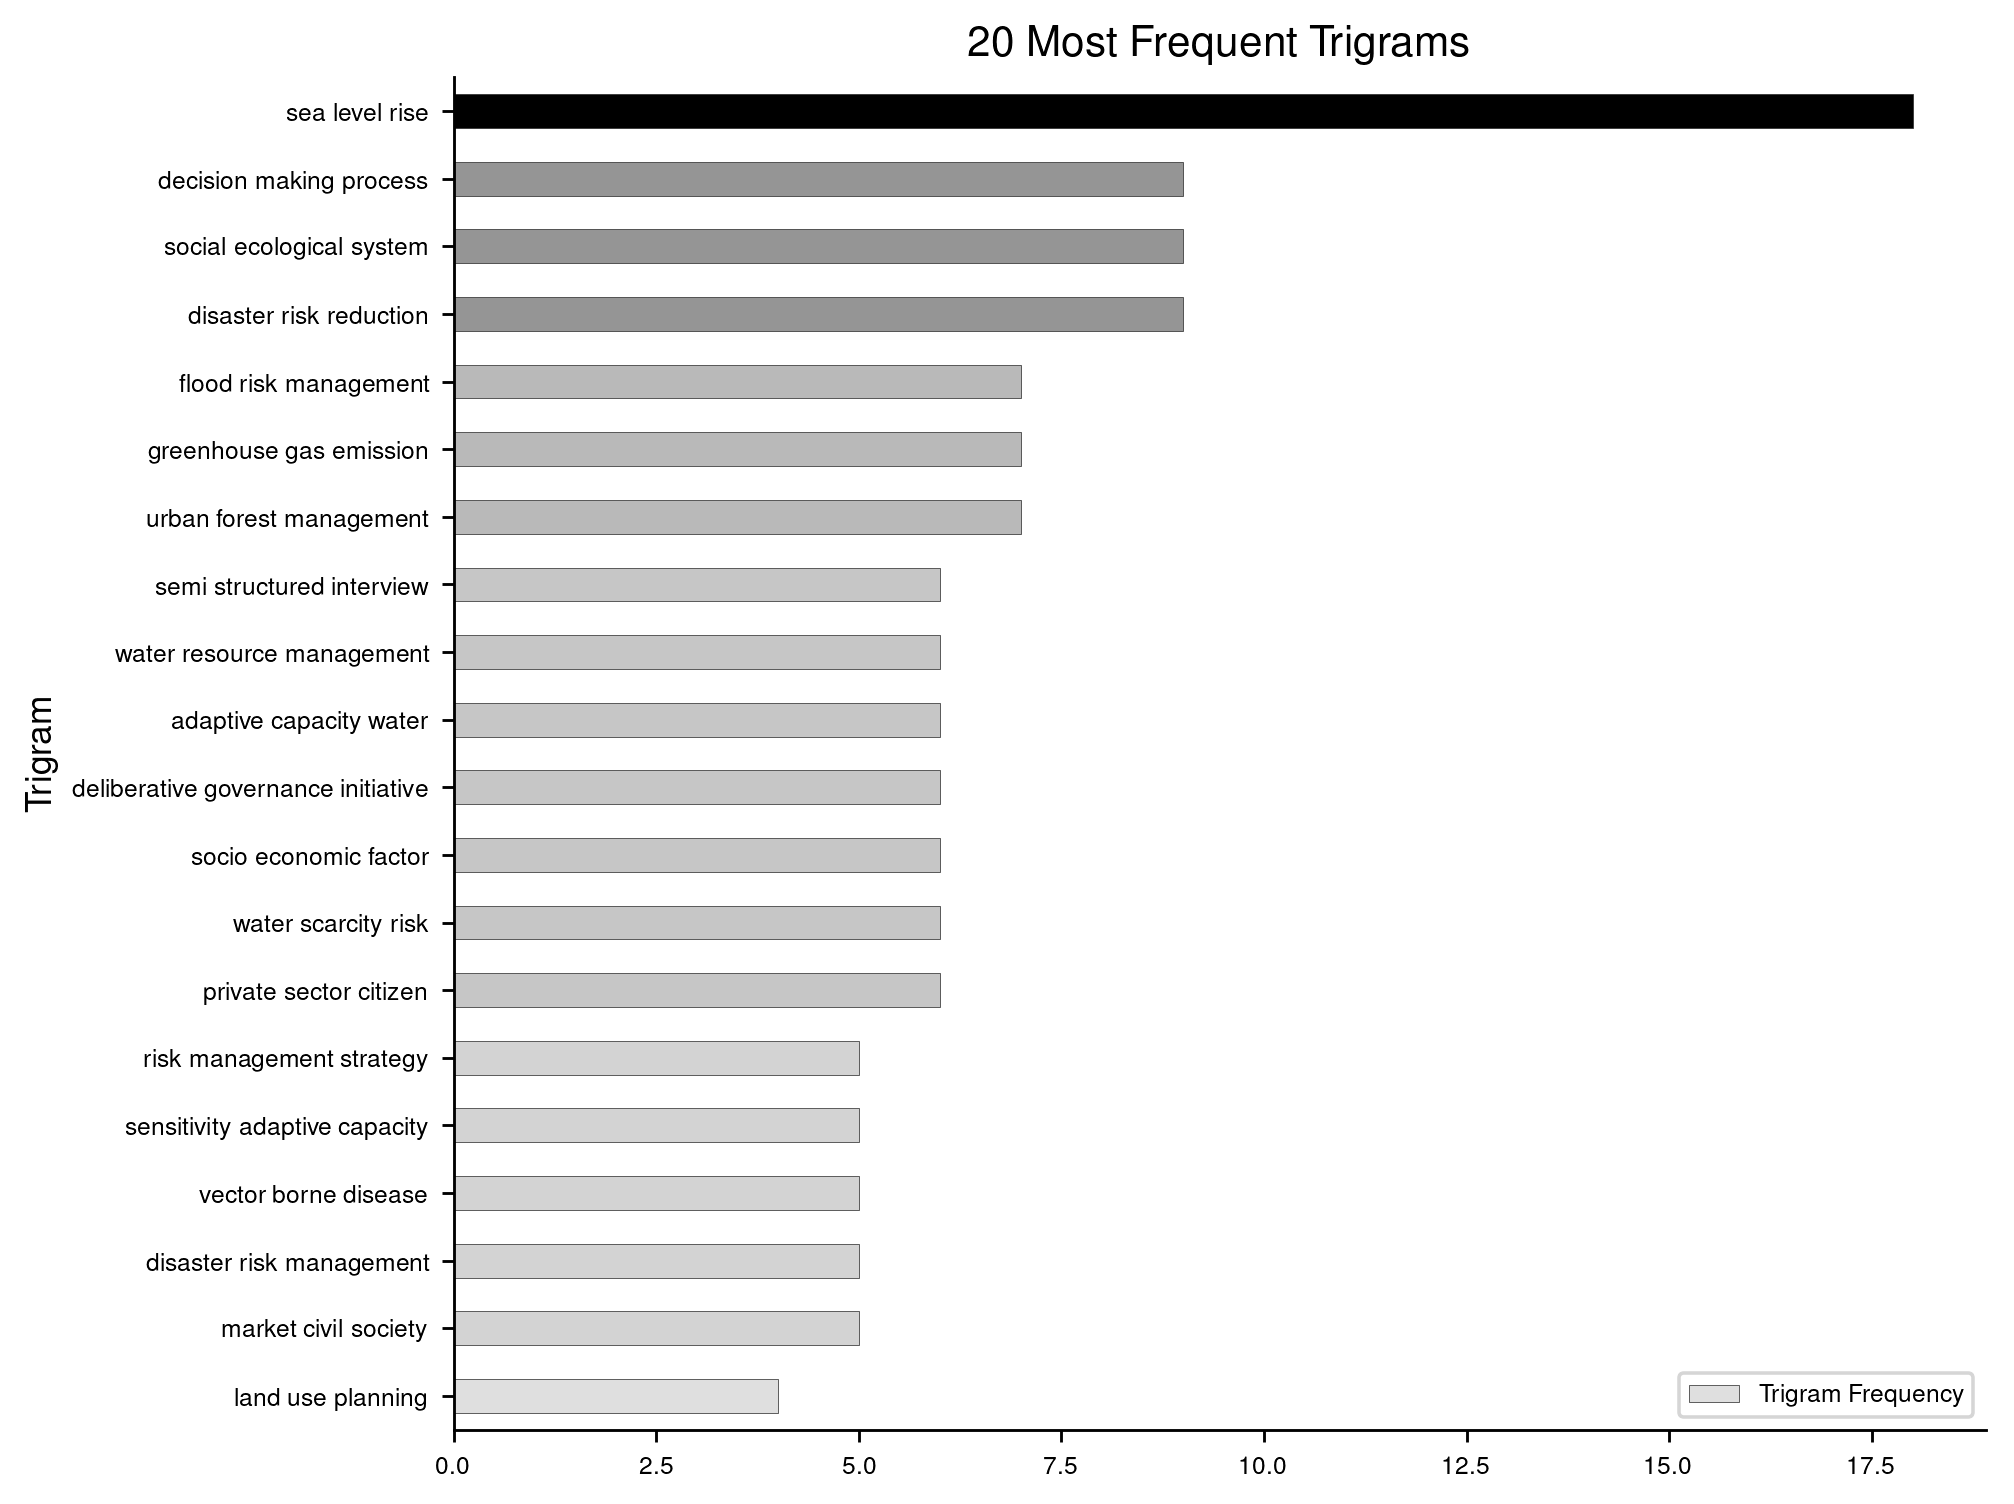

In [112]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

c = custom_bars(top3_df.sort_values(by=["Freq"]).Freq, "Greys")

top3_df.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Trigram", y="Freq", fontsize=7, color=c, edgecolor="#282828", lw=0.2
)
leg = ax.legend(["Trigram Frequency"], fontsize=7)
plt.title("20 Most Frequent Trigrams")
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("participation_trigrams.png", dpi=300)
plt.show()

In [36]:
df[df.abstract_clean.str.contains("risk")].date.groupby(df.date.dt.year).agg({"count"})

,count
date,
2000,1
2001,1
2004,1
2006,3
2008,4
2009,3
2010,10
2011,12
2012,13


In [23]:
df[df.abstract_clean.str.contains("risk")].date.groupby(df.date.dt.year).agg(
    {"count"}
).sum()

count    63
dtype: int64

# Combined Corpus

In [188]:
# earliest and latest date criteria
c_start_date = datetime(2000, 1, 1)
c_end_date = datetime(2018, 1, 1)
combined_mask = (combined["date"] >= c_start_date) & (combined["date"] <= c_end_date)

# Fit a quadratic curve to the publication counts

In [343]:
df_q = combined.loc[combined_mask].date.groupby(
    combined.date.dt.year
).agg({"count"}).reset_index()
# quadratic!
degree = 2

weights = pd.np.polynomial.polynomial.Polynomial.fit(
    df_q['date'], df_q['count'],
    degree
)
# we need the coefficients for the unscaled and unshifted basis polynomials, in reverse order
# I HAVE NO IDEA WHY THE NEW API IS SO DIFFERENT FROM THE OLD np.polyfit():
# weights = pd.np.polyfit(df_q['date'], df_q['count'], degree) <-- no convert.coef and reverse required
# poly1d requires the coefficients in decreasing powers
model = pd.np.poly1d(weights.convert().coef[::-1])
results = smf.ols(formula='count ~ model(date)', data=df_q).fit()
df_q['predicted'] = results.predict(df_q['date'])
results.summary()

/Users/sth/dev/CCA_mining/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     437.1
Date:                Mon, 10 Jun 2019   Prob (F-statistic):           1.66e-12
Time:                        12:00:36   Log-Likelihood:                -53.649
No. Observations:                  17   AIC:                             111.3
Df Residuals:                      15   BIC:                             113.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.286e-10      2.001   1.14e-10      1.000      -4.266       4.266
model(date)     1.0000      0.048     20.906      0.000       0.898       1.102
==============================================================================
Omnibus:                        1.800   Durbin-Watson:                   2.295
Prob(Omnibus):                  0.407   Jarque-Bera (JB):                0.413
Skew:                           0.242   Prob(JB):                        0.813
Kurtosis:                       3.591   Cond. No.                         57.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Figure size 432x288 with 0 Axes>

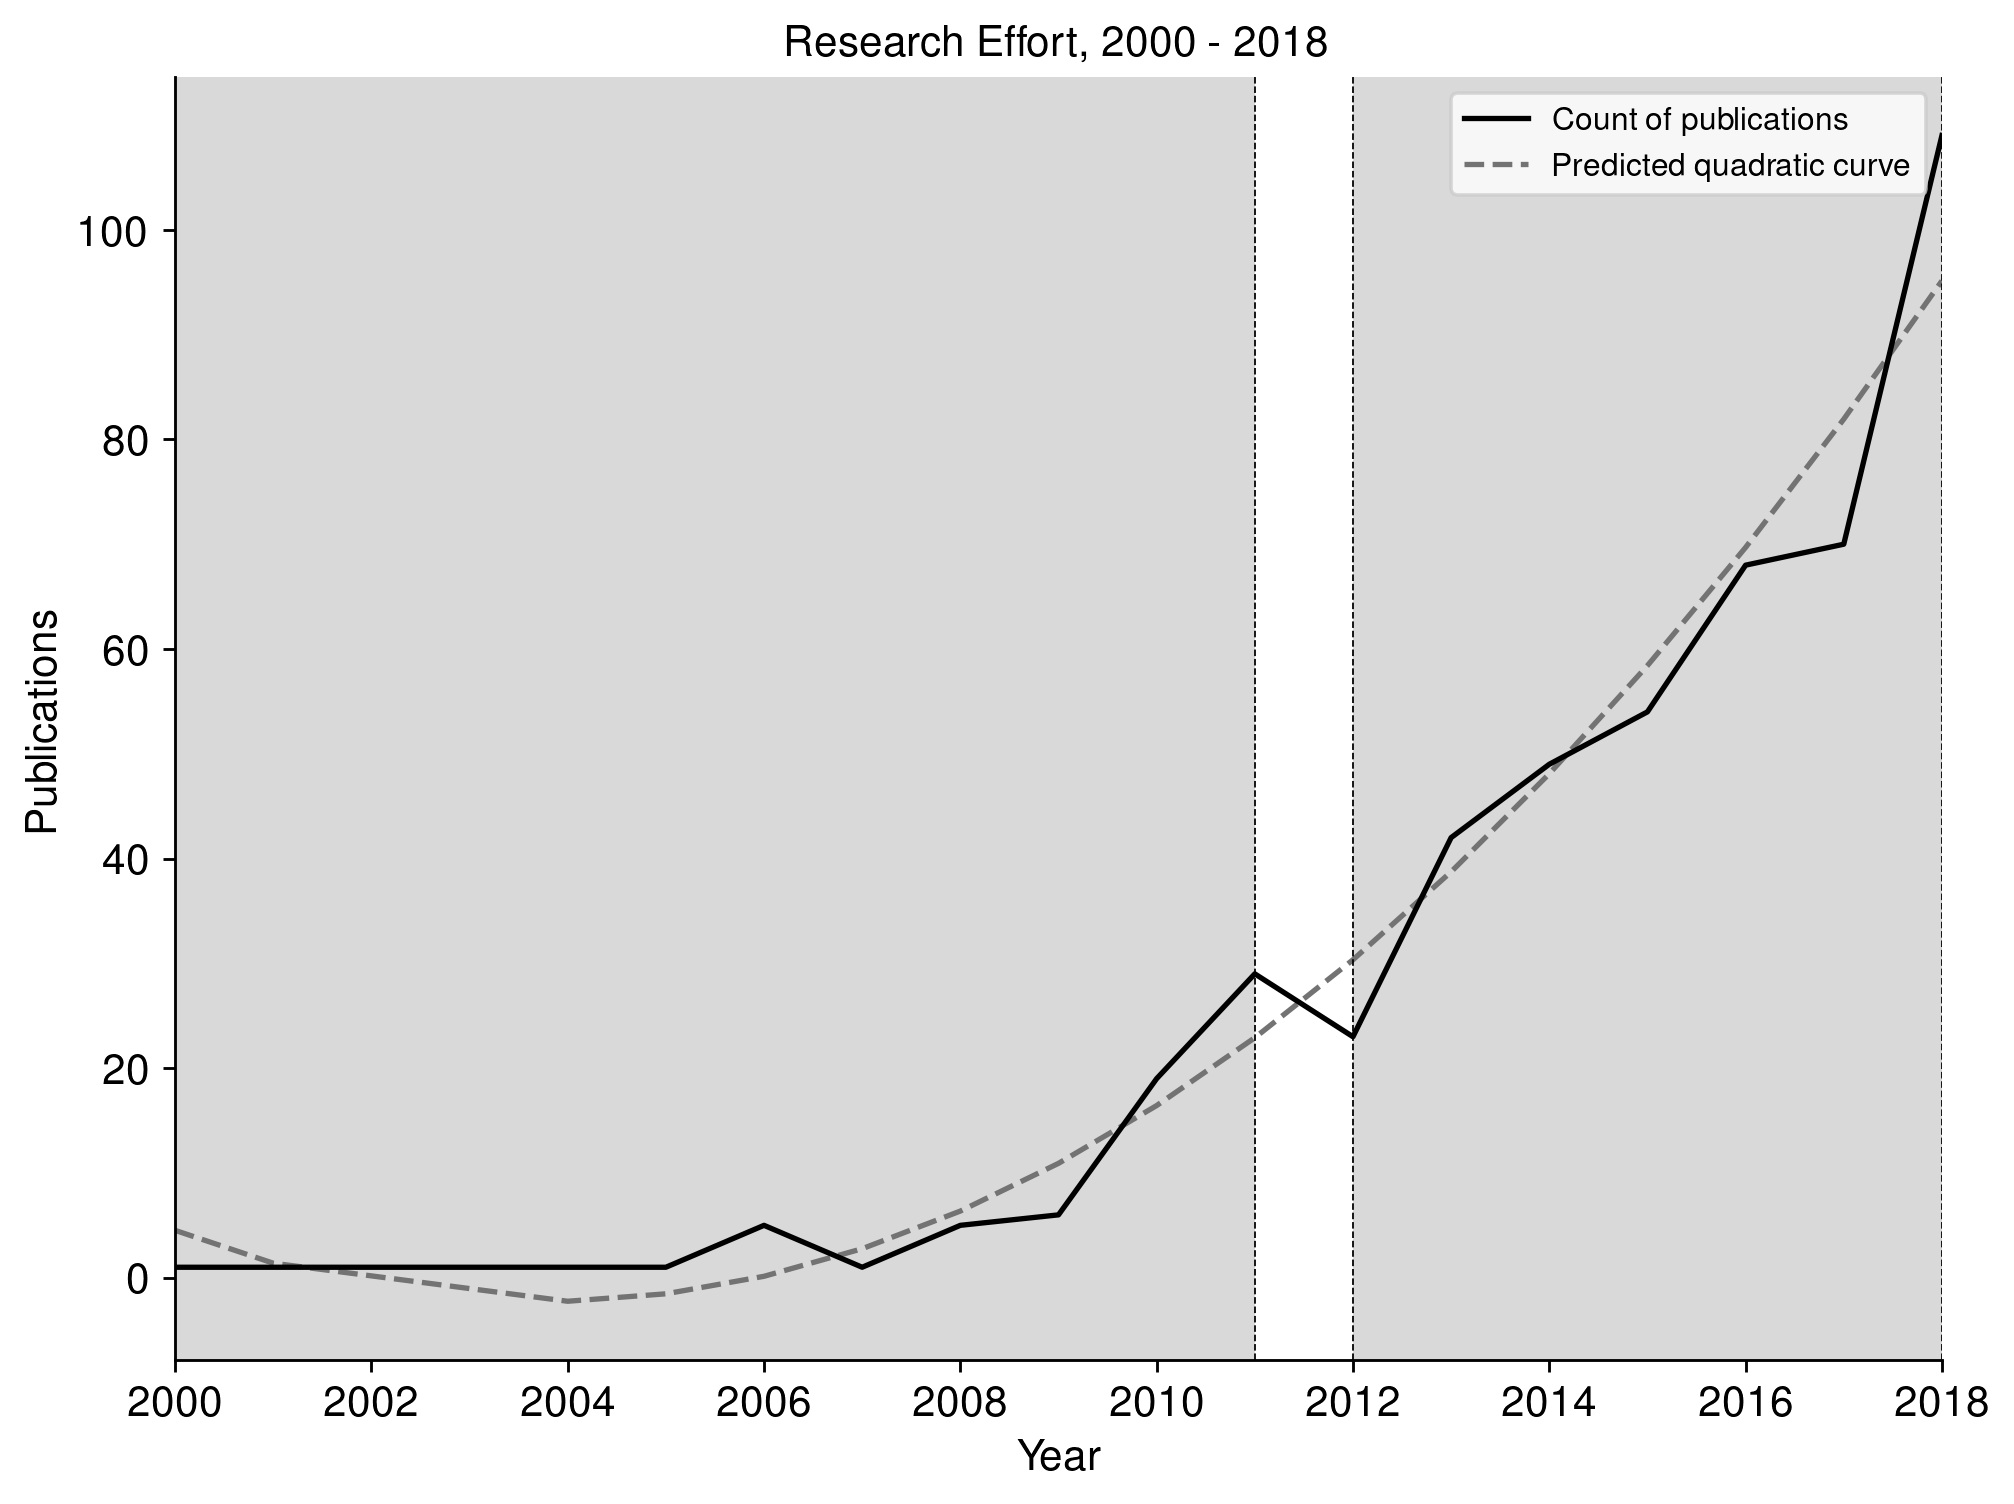

In [360]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
orig = combined.loc[combined_mask].date.groupby(combined.date.dt.year).agg({"count"}).plot(
    ax=ax,
    color="black",
    fontsize=fontsize,
    zorder=3,
#     lw=3
)


# plot fitted polynomial
pred = plt.plot(
    df_q['date'], df_q['predicted'],
    color='#737373',
    linestyle='dashed', zorder=1
)

lines = [2000, 2011, 2012, 2018]
for line in lines:
    plt.axvline(x=line, color="black", lw=0.5, linestyle="--")
plt.axvspan(2000, 2011, facecolor="#d9d9d9", alpha=1.)
plt.axvspan(2012, 2018, facecolor="#d9d9d9", alpha=1.)
# plt.axvspan(2017, 2018, facecolor="grey", alpha=0.3)

ax.set_ylabel("Publications", fontsize=fontsize)
plt.title("Research Effort, 2000 - 2018")
ax.set_xlabel("Year", fontsize=fontsize)
leg = ax.legend(["Count of publications", "Predicted quadratic curve"], fontsize=9)
plt.tight_layout()
plt.savefig("combined_time.png", dpi=300)
plt.savefig("combined_time.eps", dpi=300)
plt.show()



In [92]:
combined_top_words = get_top_n_words(combined.abstract_clean, n=20)
top_combined = pd.DataFrame(combined_top_words)
top_combined.columns = ["Word", "Freq"]

In [200]:
len(combined.set_index('date').loc['1992-01-01':'2011-01-01'])

69

In [197]:
len(combined.set_index('date').loc['2012-01-01':'2018-01-01'])

415

In [227]:
combined.set_index('date').loc['1992-01-01':'2018-01-01'].groupby(lambda x: x.year).agg(['count'])

,title,creator,abstract,doi,publication,date_added,abstract_clean,word_count
,count,count,count,count,count,count,count,count
2000,1,1,1,1,1,1,1,0
2001,1,1,1,1,1,1,1,0
2004,1,1,1,1,1,1,1,0
2005,1,0,1,0,0,0,1,1
2006,5,3,5,3,3,3,5,2
2007,1,0,1,0,0,0,1,1
2008,5,4,5,4,4,4,5,1
2009,6,3,6,3,3,3,6,3
2010,19,10,19,10,10,10,19,9


In [216]:
combined.set_index('date').loc['2012-01-01':'2018-01-01'].groupby(lambda x: x.year).agg(['count'])

,title,creator,abstract,doi,publication,date_added,abstract_clean,word_count
,count,count,count,count,count,count,count,count
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,0.826087,0.538462,0.826087,0.538462,0.538462,0.538462,0.826087,1.200000
2014,0.166667,0.050000,0.166667,0.050000,0.050000,0.050000,0.166667,0.272727
2015,0.102041,0.047619,0.102041,0.047619,0.047619,0.047619,0.102041,0.142857
2016,0.259259,0.272727,0.259259,0.272727,0.272727,0.272727,0.259259,0.250000
2017,0.029412,0.321429,0.029412,0.321429,0.321429,0.321429,0.029412,-0.175000
2018,0.557143,0.405405,0.557143,0.405405,0.405405,0.405405,0.557143,0.727273


In [226]:
combined.set_index('date').loc['2000-01-01':'2018-01-01']['title'].resample("Y").count().pct_change()

date
2000-12-31         NaN
2001-12-31    0.000000
2002-12-31   -1.000000
2003-12-31         NaN
2004-12-31         inf
2005-12-31    0.000000
2006-12-31    4.000000
2007-12-31   -0.800000
2008-12-31    4.000000
2009-12-31    0.200000
2010-12-31    2.166667
2011-12-31    0.526316
2012-12-31   -0.206897
2013-12-31    0.826087
2014-12-31    0.166667
2015-12-31    0.102041
2016-12-31    0.259259
2017-12-31    0.029412
2018-12-31    0.557143
Freq: A-DEC, Name: title, dtype: float64

In [228]:
combined.set_index('date').loc['2000-01-01':'2018-01-01']['title'].resample("Y").count().diff()

date
2000-12-31     NaN
2001-12-31     0.0
2002-12-31    -1.0
2003-12-31     0.0
2004-12-31     1.0
2005-12-31     0.0
2006-12-31     4.0
2007-12-31    -4.0
2008-12-31     4.0
2009-12-31     1.0
2010-12-31    13.0
2011-12-31    10.0
2012-12-31    -6.0
2013-12-31    19.0
2014-12-31     7.0
2015-12-31     5.0
2016-12-31    14.0
2017-12-31     2.0
2018-12-31    39.0
Freq: A-DEC, Name: title, dtype: float64

<Figure size 432x288 with 0 Axes>

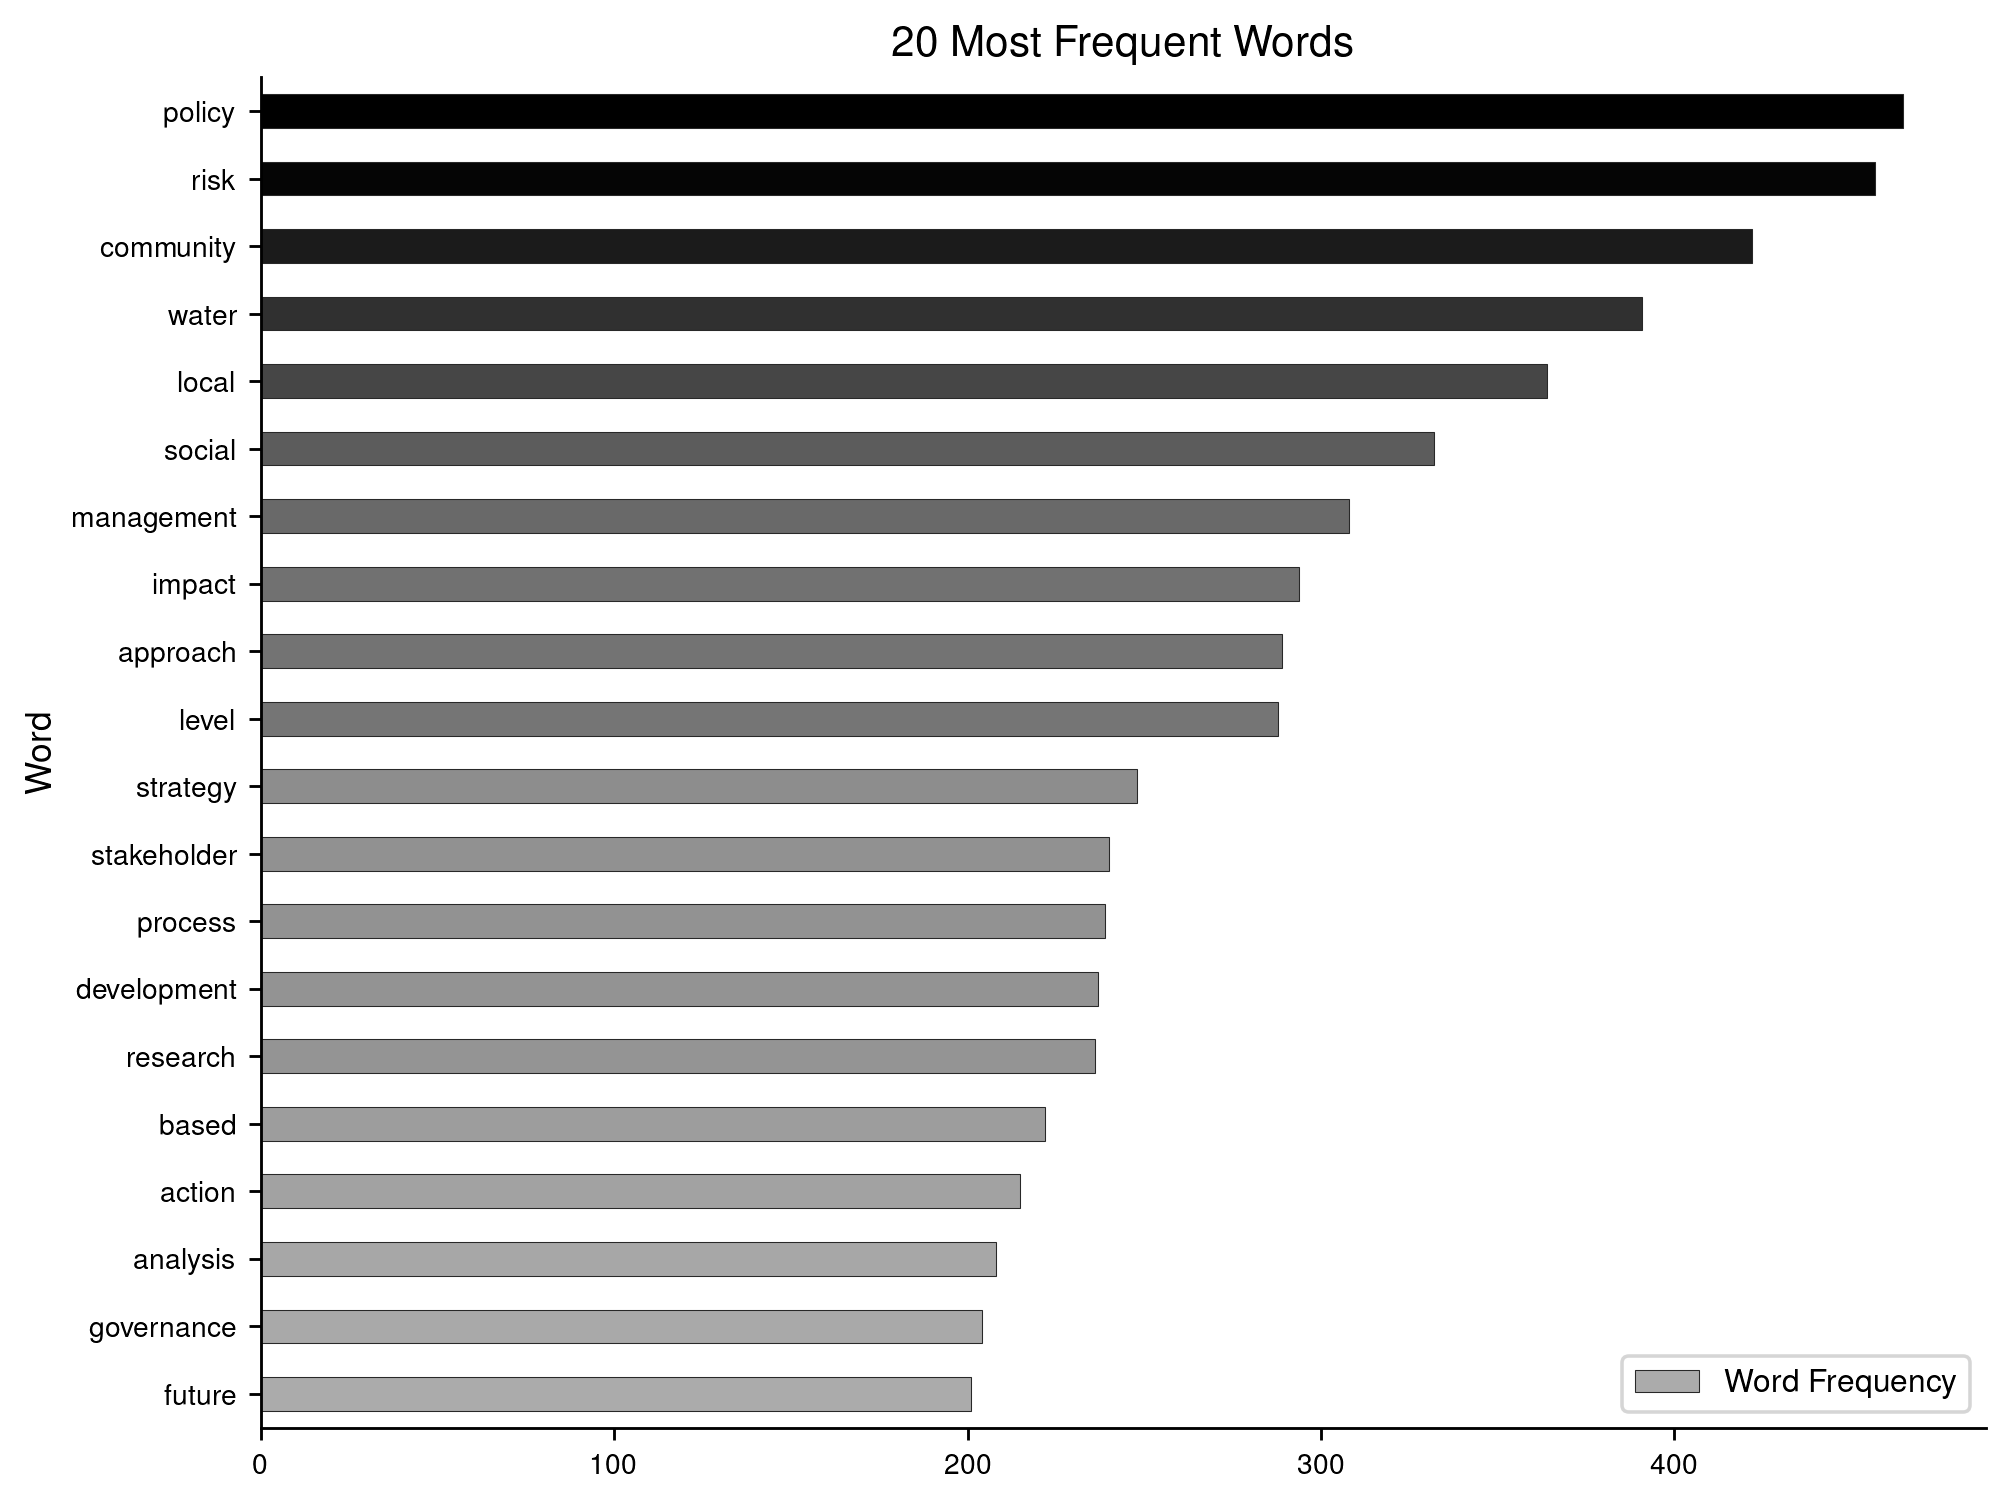

In [231]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

c = custom_bars(top_combined.sort_values(by=["Freq"]).Freq, "Greys")

top_combined.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Word", y="Freq", fontsize=8, color=c, edgecolor="#282828", lw=0.3
)
leg = ax.legend(["Word Frequency"], fontsize=9)
plt.title("20 Most Frequent Words")
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("combined_words_single.png", dpi=300)
plt.savefig("combined_words_single.eps", dpi=300)
plt.show()

In [94]:
top2_combined = get_top_n2_words(combined.abstract_clean, n=20)
top2_combined = pd.DataFrame(top2_combined)
top2_combined.columns = ["Bigram", "Freq"]

<Figure size 432x288 with 0 Axes>

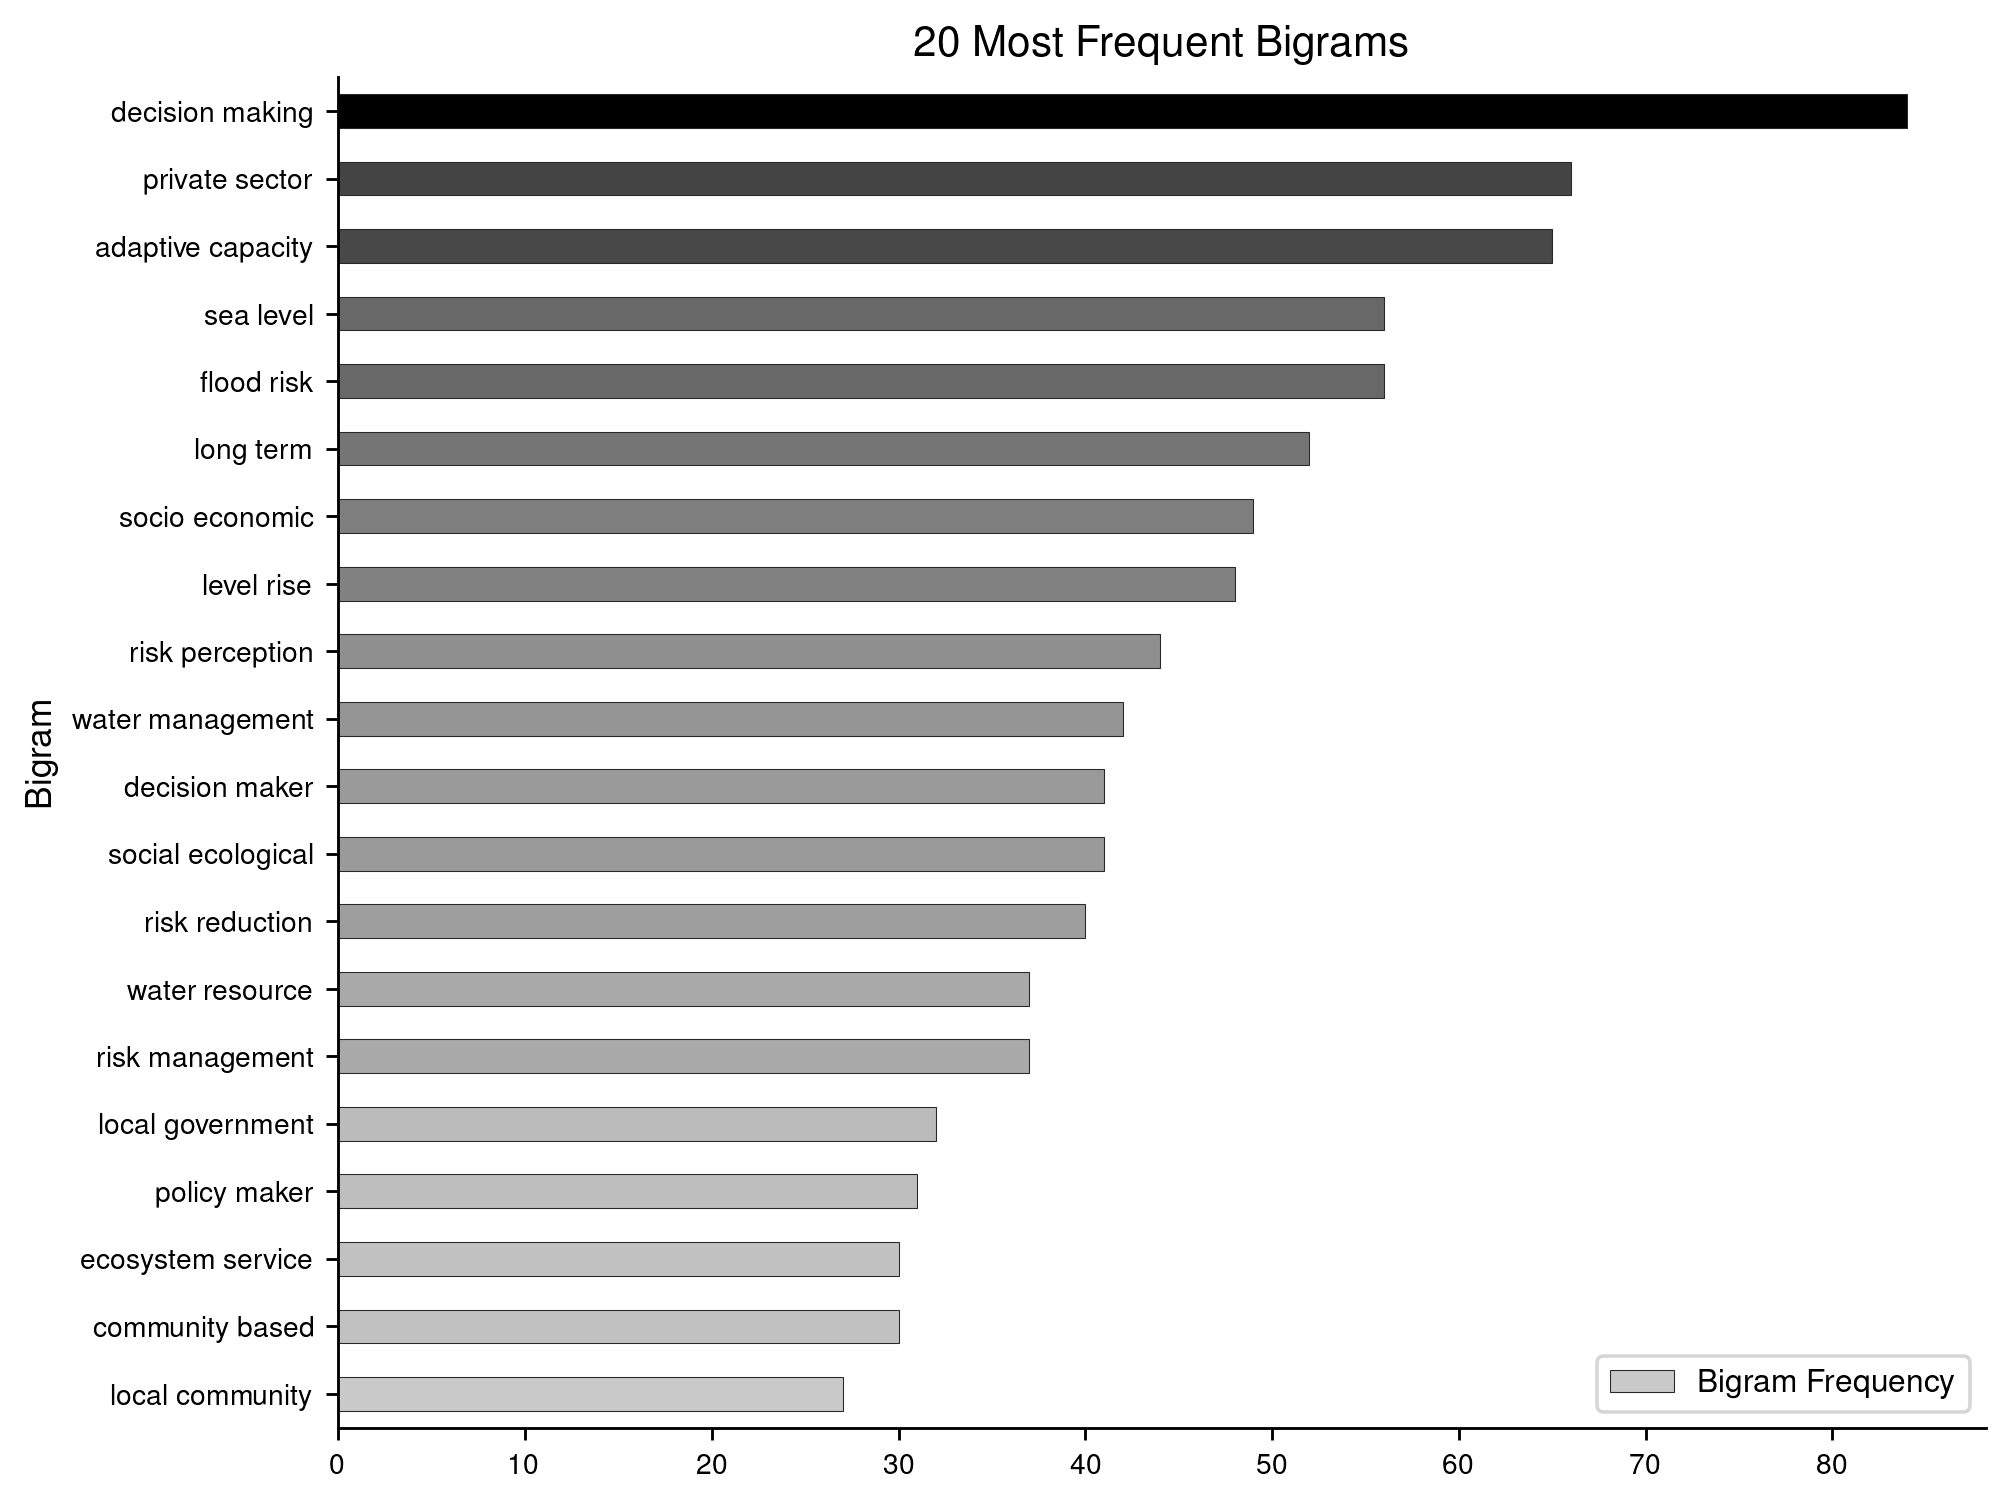

In [230]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

c = custom_bars(top2_combined.sort_values(by=["Freq"]).Freq, "Greys")

top2_combined.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Bigram", y="Freq", fontsize=8, color=c, edgecolor="#282828", lw=0.3
)
plt.title("20 Most Frequent Bigrams")
leg = ax.legend(["Bigram Frequency"], fontsize=9)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("combined_bigrams.png", dpi=300)
plt.savefig("combined_bigrams.eps", dpi=300)
plt.show()

In [96]:
top3_combined = get_top_n3_words(combined.abstract_clean, n=20)
top3_combined = pd.DataFrame(top3_combined)
top3_combined.columns = ["Trigram", "Freq"]

<Figure size 432x288 with 0 Axes>

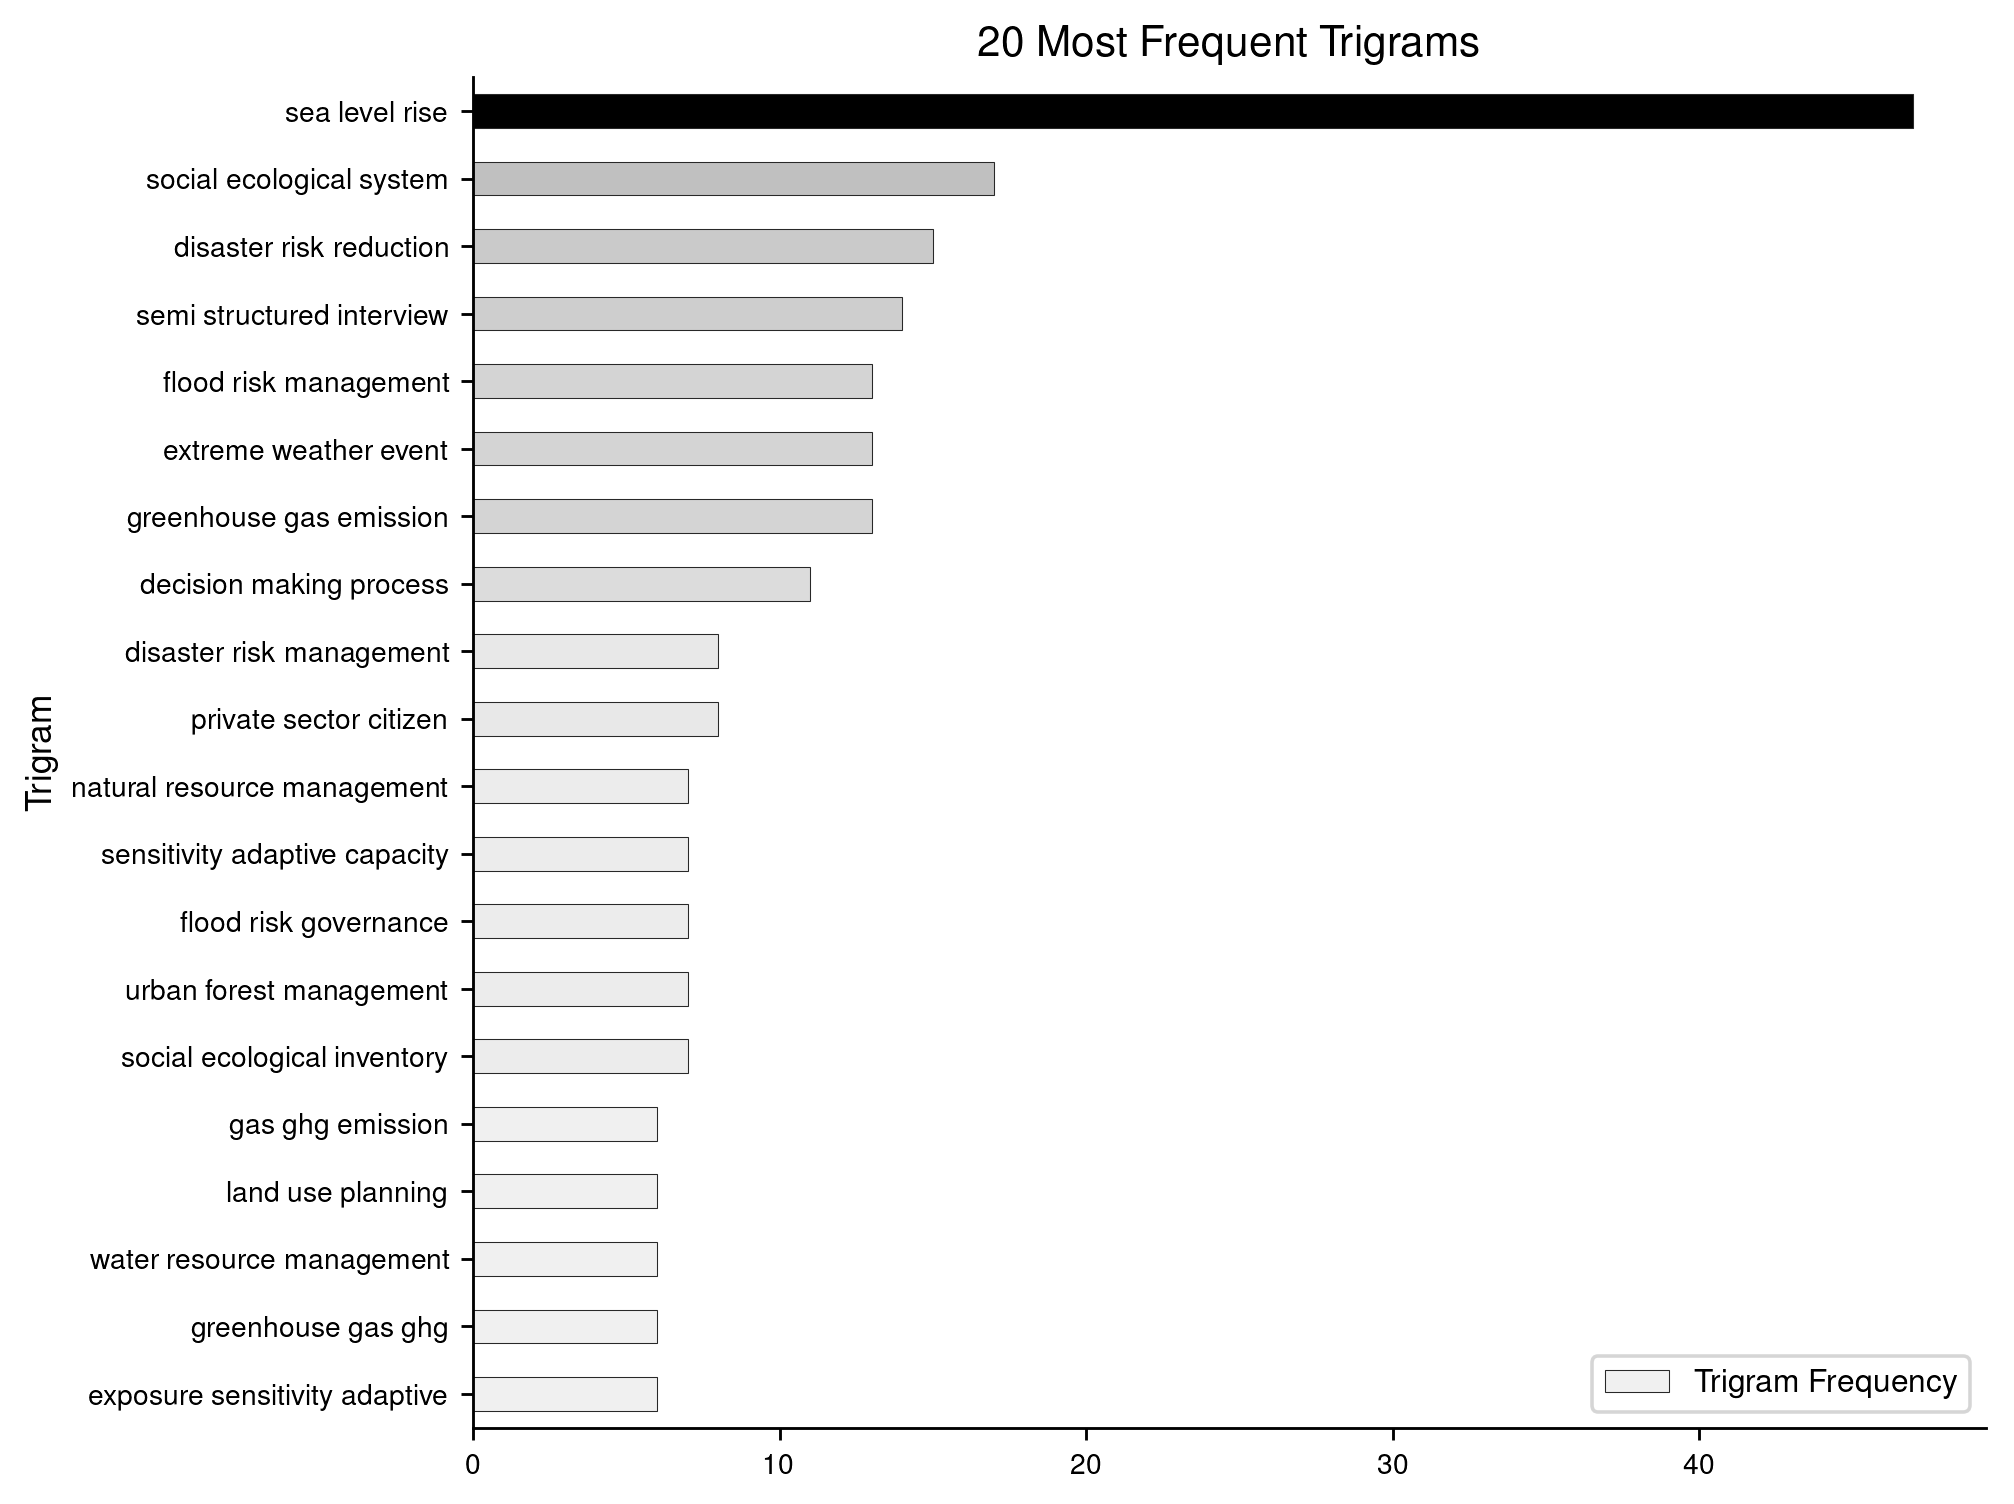

In [229]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

c = custom_bars(top3_combined.sort_values(by=["Freq"]).Freq, "Greys")

top3_combined.sort_values(by=["Freq"]).plot.barh(
    ax=ax, x="Trigram", y="Freq", fontsize=8, color=c, edgecolor="#282828", lw=0.3
)
plt.title("20 Most Frequent Trigrams")
leg = ax.legend(["Trigram Frequency"], fontsize=9)
ax.grid(b=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_facecolor("none")
plt.tight_layout()
plt.savefig("combined_trigrams.png", dpi=300)
plt.savefig("combined_trigrams.eps", dpi=300)
plt.show()

In [122]:
len(combined)

486

In [123]:
len(df)

228

In [124]:
len(df_b)

258

In [361]:
combined.date.groupby(combined.date.dt.year).agg({"count"}).sum()

count    486
dtype: int64

In [187]:
combined.date.groupby(combined.date.dt.year).agg({"count"})



,count
date,
2000,1
2001,1
2004,1
2005,1
2006,5
2007,1
2008,5
2009,6
2010,19


In [126]:
df_b[df_b.abstract_clean.str.contains("flood")].date.groupby(df_b.date.dt.year).agg({"count"})



,count
date,
2005,1
2007,1
2011,2
2012,1
2013,4
2014,3
2015,3
2016,7
2017,9


In [152]:
r3 = combined[combined.abstract_clean.str.contains(
    "risk communication|risk assessment|risk perception", regex=True
)]
r3

,title,creator,date,abstract,doi,publication,date_added,abstract_clean,word_count
81,Climate change awareness and strategies for co...,Lieske et al.,2014-01-01,"Rising sea levels, due to thermal expansion of...",10.1016/j.ecss.2013.04.017,Estuarine Coastal and Shelf Science,2019-06-05 12:17:51+00:00,rising sea level due thermal expansion ocean h...,NaN
97,A dynamic assessment of water scarcity risk in...,Gain and Giupponi,2015-01-01,Many international river basins are likely to ...,10.1016/j.ecolind.2014.07.034,Ecological Indicators,2019-06-05 12:17:51+00:00,many international river basin likely experien...,NaN
123,Recommendations for Capacity Development in Wa...,Bormann et al.,2016-01-01,Socioeconomic development often causes environ...,10.1007/s11269-016-1359-x,Water Resources Management,2019-06-05 12:17:51+00:00,socioeconomic development often cause environm...,NaN
157,Role of community based local institution for ...,Karim and Thiel,2017-01-01,Climate change adaptation is one of the most c...,10.1016/j.crm.2017.06.002,Climate Risk Management,2019-06-05 12:17:51+00:00,crucial issue developing country like banglade...,NaN
158,What does resilience mean for urban water serv...,Johannessen and Wamsler,2017-01-01,"Disasters and climate change impacts, as well ...",10.5751/ES-08870-220101,Ecology and Society,2019-06-05 12:17:51+00:00,disaster impact well increased water demand po...,NaN
174,Should We Leave? Attitudes towards Relocation ...,Song and Peng,2017-01-01,The participation of individuals contributes s...,10.3390/w9120941,Water,2019-06-05 12:17:51+00:00,participation individual contributes significa...,NaN
181,How a coastal community looks at coastal hazar...,Domingues et al.,2018-01-01,Faro Beach is a vulnerable and heavily urbaniz...,10.1016/j.ocecoaman.2018.03.015,Ocean & Coastal Management,2019-06-05 12:17:51+00:00,faro beach vulnerable heavily urbanized settle...,NaN
191,Linking livestock snow disastermortality and e...,Li et al.,2018-01-01,Livestock snowdisaster occurswidely in Central...,10.1016/j.scitotenv.2017.12.230,Science of the Total Environment,2019-06-05 12:17:51+00:00,livestock snowdisaster occurswidely central ea...,NaN
224,Participatory early warning and monitoring sys...,Henriksen et al.,2018-01-01,This paper reviews recent hydrological risk as...,10.1016/j.ijdrr.2018.01.038,International Journal of Disaster Risk Reduction,2019-06-05 12:17:51+00:00,review recent hydrological risk assessment com...,NaN
241,Community level adaptation to climate change: ...,NaN,2008-01-01,This paper explores the value of using communi...,NaN,NaN,NaT,explores value community risk assessment cras ...,260.0


In [153]:
len(r3)

37

<Figure size 432x288 with 0 Axes>

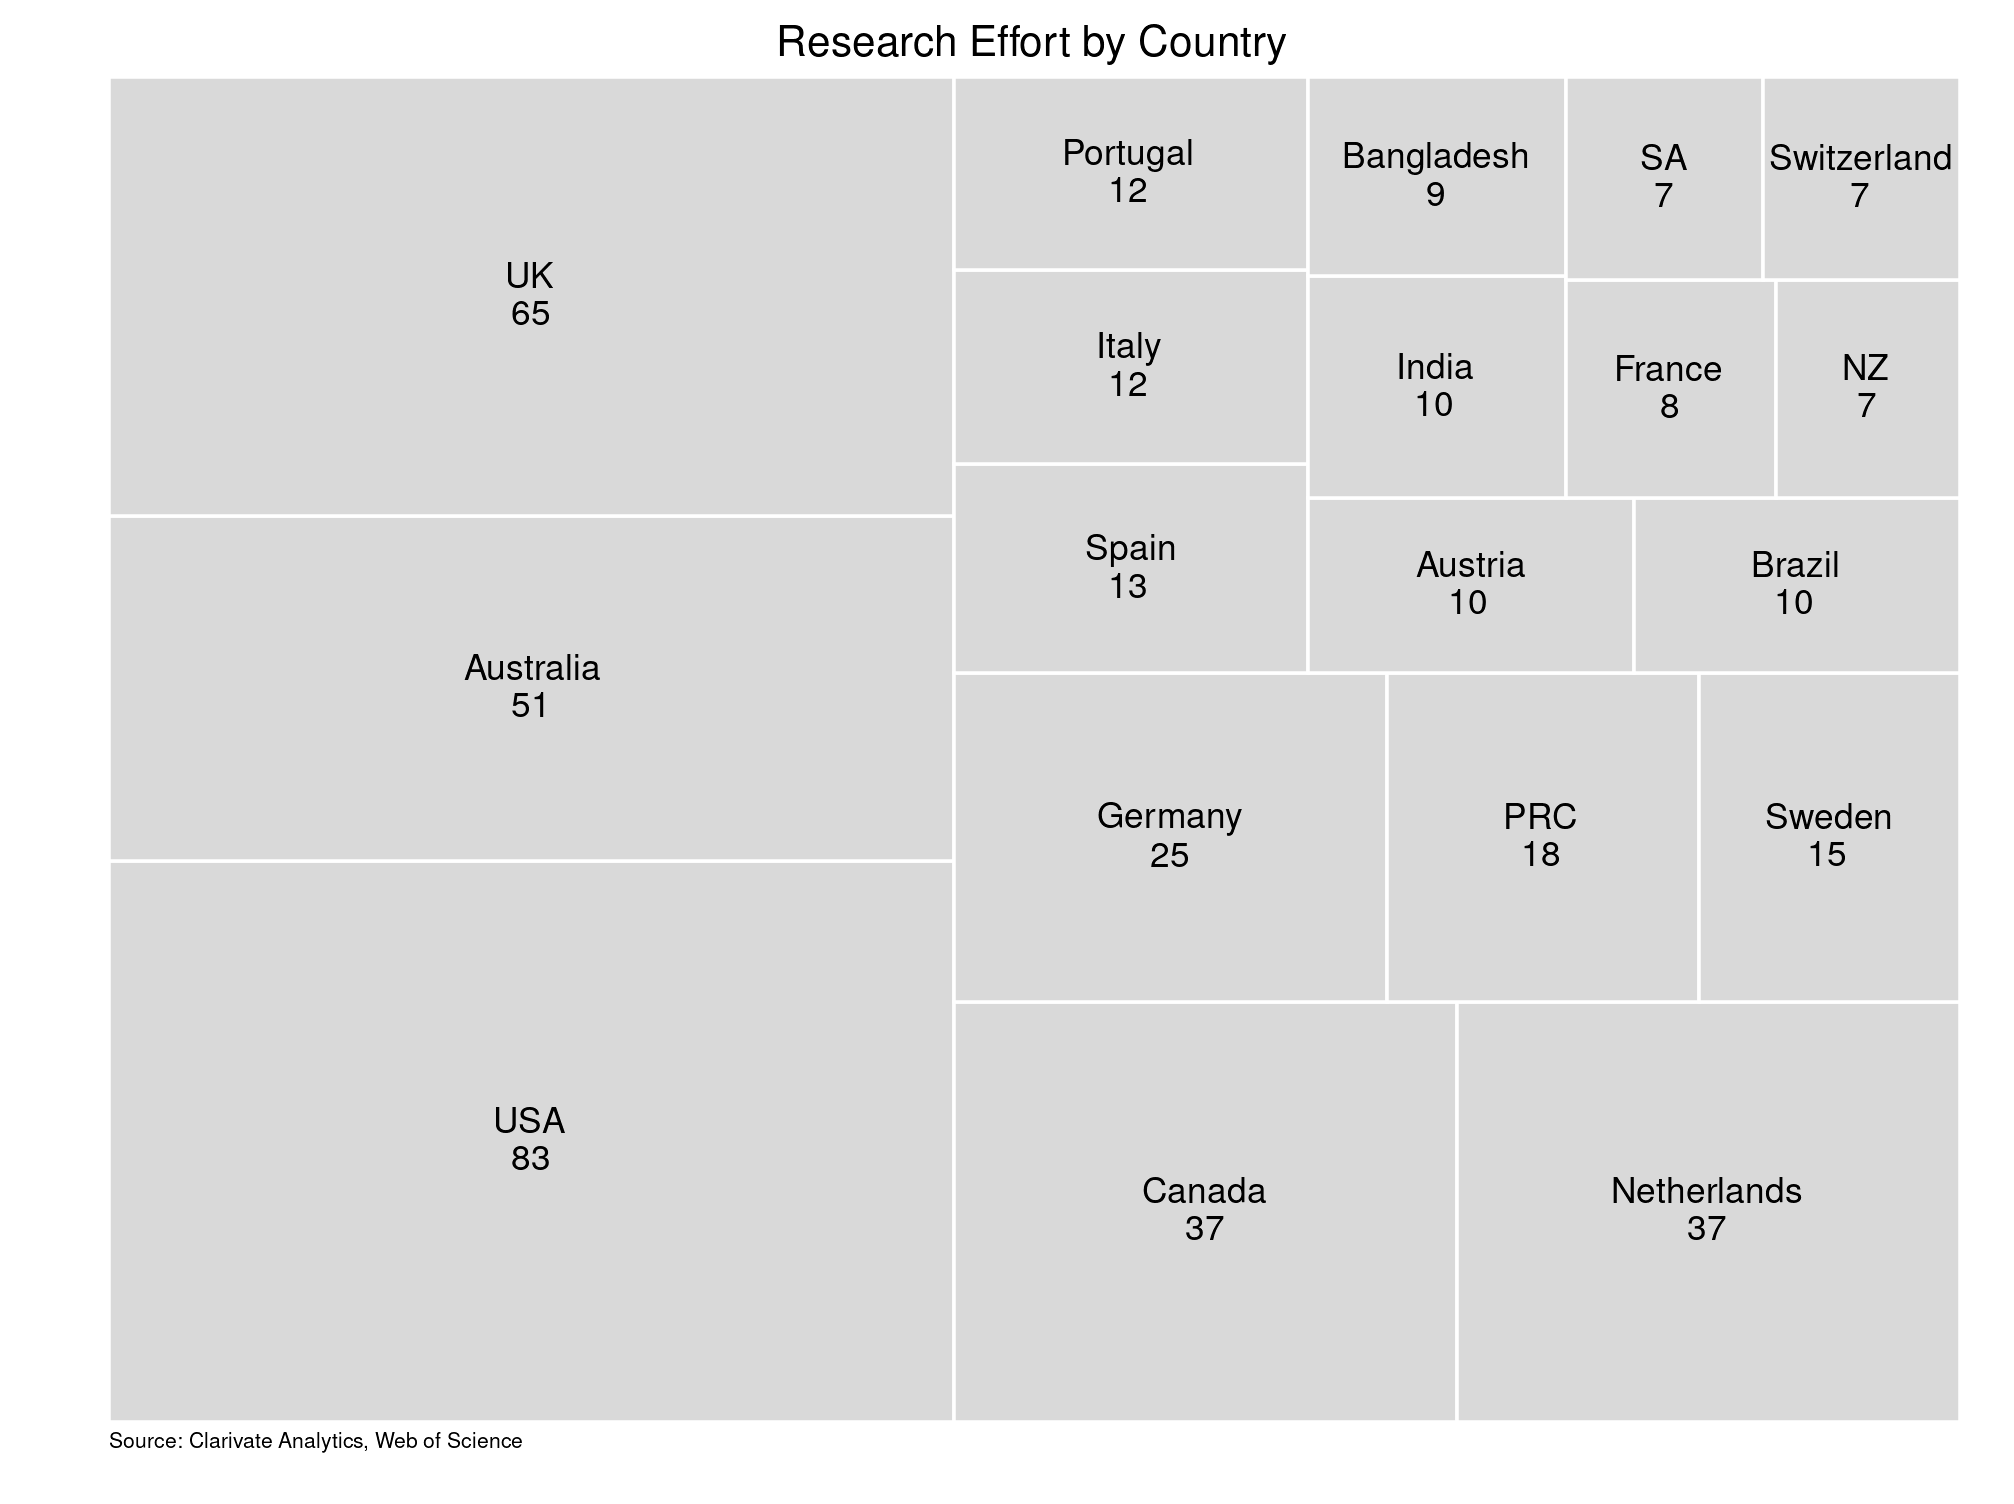

In [237]:
volume = pd.np.array(
    [83, 51, 65, 37, 37, 25, 18, 15, 13, 12, 12, 10, 10, 10, 9, 8, 7, 7, 7]
)

countries = [
    "USA",
    "Australia",
    "UK",
    "Canada",
    "Netherlands",
    "Germany",
    "PRC",
    "Sweden",
    "Spain",
    "Italy",
    "Portugal",
    "Austria",
    "Brazil",
    "India",
    "Bangladesh",
    "France",
    "NZ",
    "SA",
    "Switzerland"
]

labels = ["%s\n%s" % (c, n) for c, n in zip(countries, volume)]
colour_list = ["#d9d9d9"] * len(volume)

plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

squarify.plot(
    ax=ax,
    sizes=volume,
    label=labels,
    color=colour_list,
    alpha=1.0,
    text_kwargs={"fontsize": 10, "fontweight": "bold"},
    bar_kwargs={"edgecolor": "white", "linewidth": 1.0}
)

txt = "Source: Clarivate Analytics, Web of Science"
fig.text(0.06, 0.045, txt, ha='left', size=6)
plt.title("Research Effort by Country")
plt.axis("off")
plt.tight_layout()
plt.savefig("countries_combined.png", dpi=300)
plt.savefig("countries_combined.eps", dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

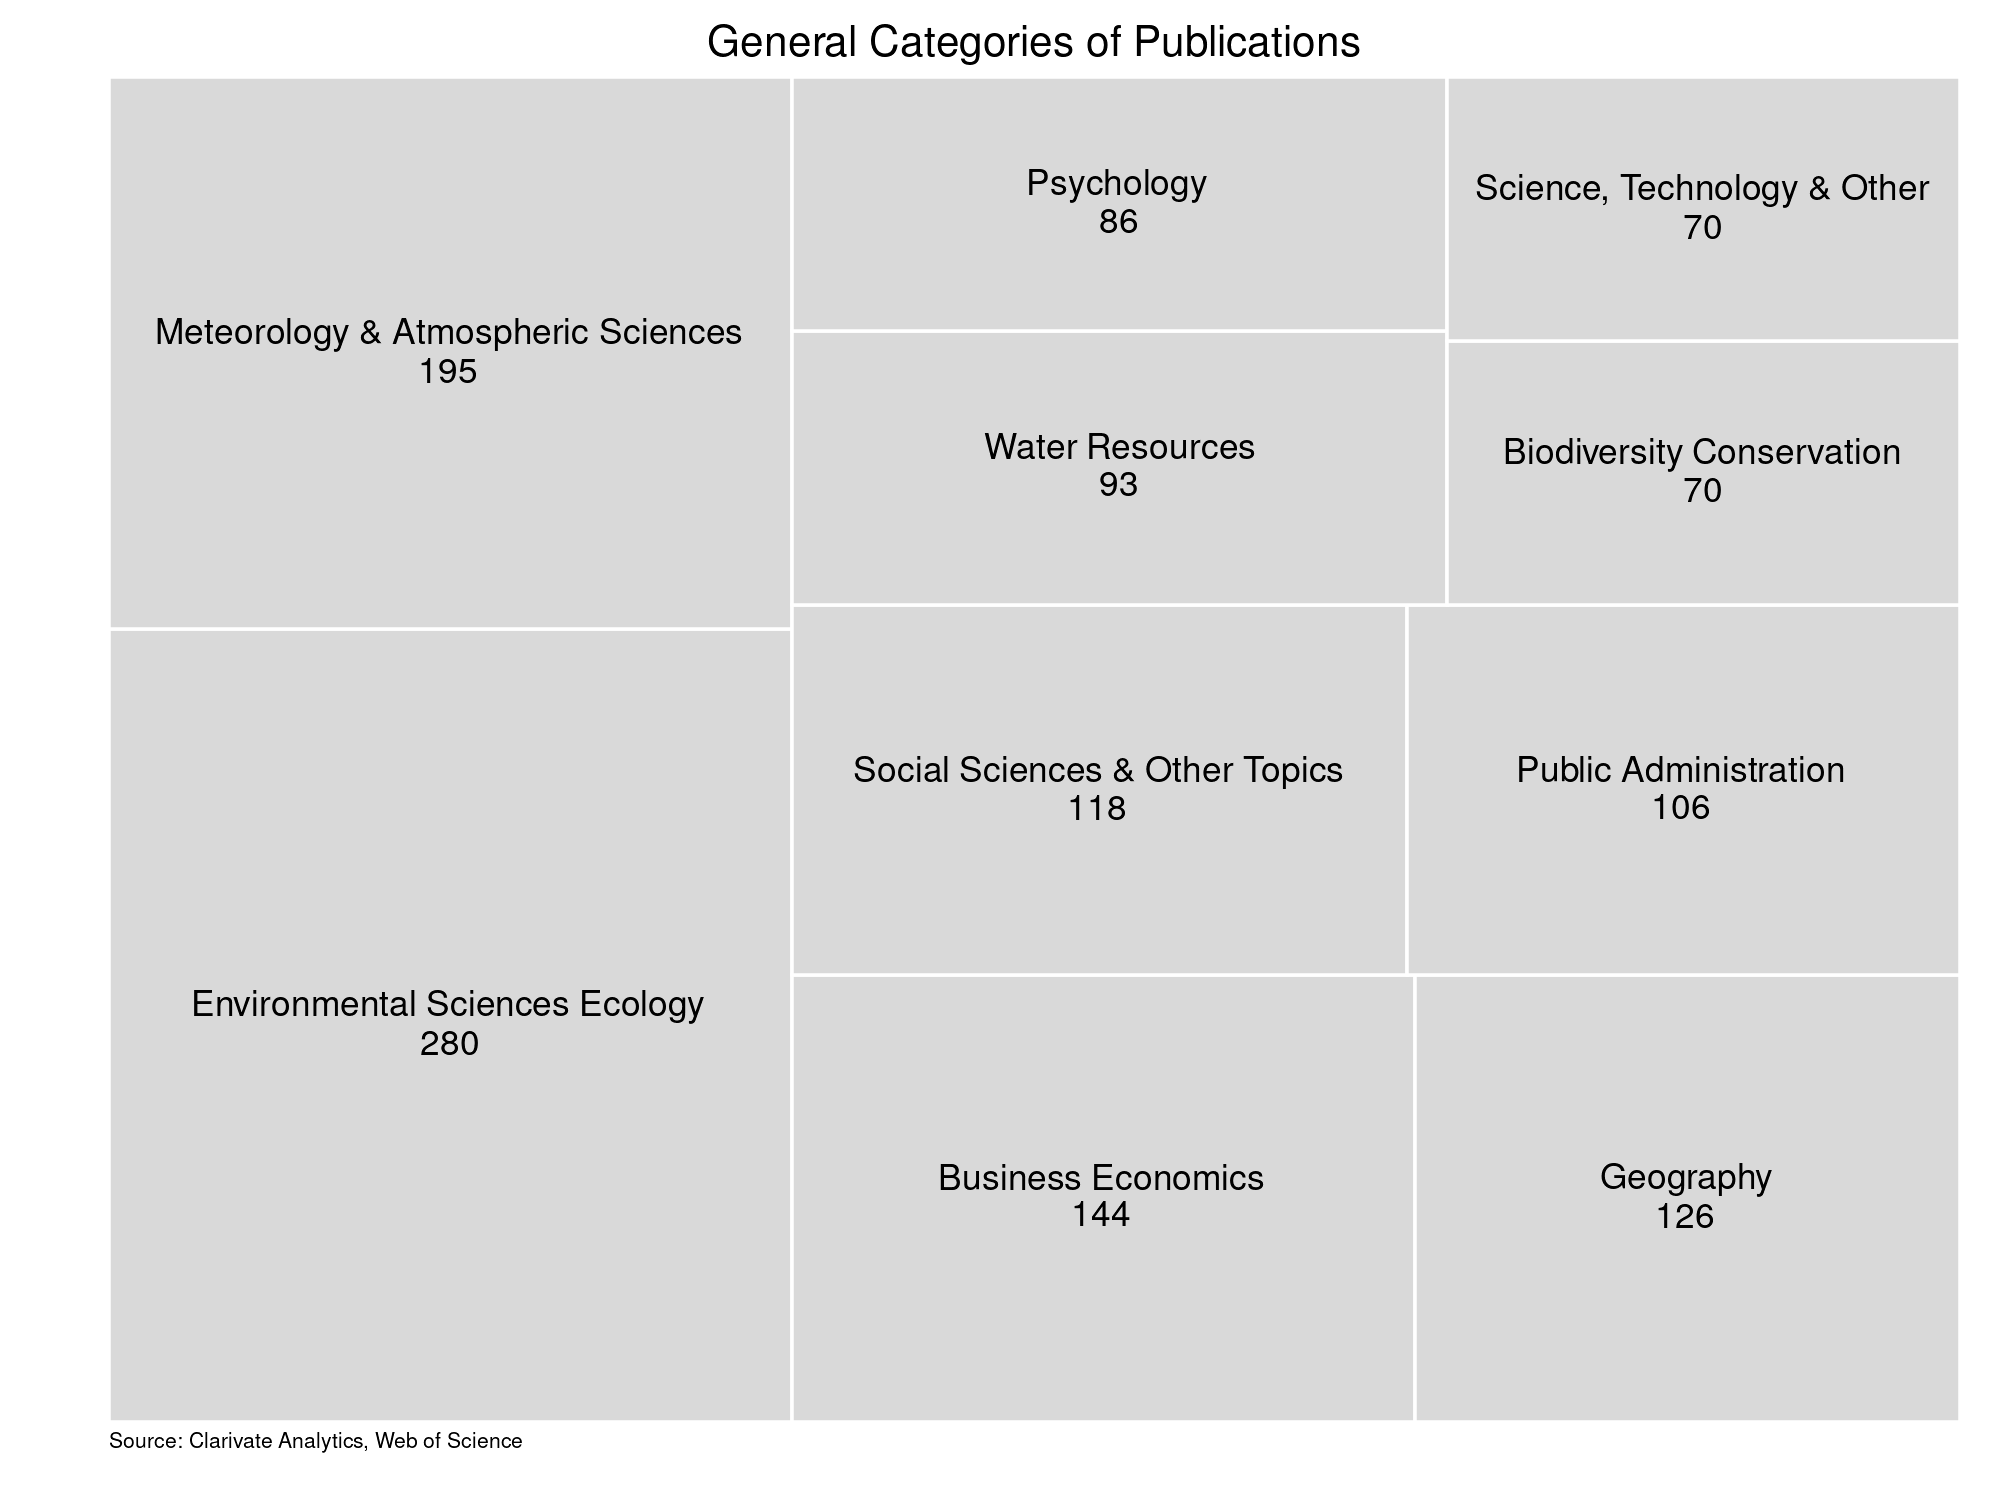

In [236]:
volume = pd.np.array(
    [280, 195, 144, 126, 118, 106, 93, 86, 70, 70]
)

topics = [
    "Environmental Sciences Ecology",
    "Meteorology \& Atmospheric Sciences",
    "Business Economics",
    "Geography",
    "Social Sciences \& Other Topics",
    "Public Administration",
    "Water Resources",
    "Psychology",
    "Biodiversity Conservation",
    "Science, Technology \& Other",
]

labels = ["%s\n%s" % (c, n) for c, n in zip(topics, volume)]
colour_list = ["#d9d9d9"] * len(volume)

plt.clf()
fig, ax = plt.subplots(1, figsize=(8.0, 6.0), dpi=255)

squarify.plot(
    ax=ax,
    sizes=volume,
    label=labels,
    color=colour_list,
    alpha=1.0,
    text_kwargs={"fontsize": 10, "fontweight": "bold"},
    bar_kwargs={"edgecolor": "white", "linewidth": 1.0}
)

txt = "Source: Clarivate Analytics, Web of Science"
fig.text(0.06, 0.045, txt, ha='left', size=6)
plt.title("General Categories of Publications")
plt.axis("off")
plt.tight_layout()
plt.savefig("topics_combined.png", dpi=300)
plt.savefig("topics_combined.eps", dpi=300)
plt.show()

In [177]:
combined.iloc[309]['abstract']

"Communities of Alaska's North Slope face increased stresses from cumulative effects of industrial development, resource use, and changing cryospheric and socioeconomic conditions. Given these multiple pressures, what avenues exist for citizens and decision makers to exchange knowledge about impacts of oil resource extraction in Alaska, and how do the successes and failures of knowledge exchange affect the resilience of the local social ecological system? We focused our research on the risk management process of Alaska North Slope oil resources, drawing on literature that has grown out of the risk society thesis and concepts of resilience science. We surveyed state and federal initiatives designed to increase local and indigenous stakeholder engagement in science and policy issues because such guidelines and regulations impact on the abilities of local peoples and communities to adapt sustainability strategies. Perceived risks and desired outcomes of stakeholders on the front lines of 

In [178]:
combined.iloc[309]['abstract_clean']

'community alaska north slope face increased stress cumulative effect industrial development resource use changing cryospheric socioeconomic condition given multiple pressure avenue exist citizen decision maker exchange knowledge impact oil resource extraction alaska success failure knowledge exchange affect resilience local social ecological system focused research risk management process alaska north slope oil resource drawing literature grown risk society thesis concept resilience science surveyed state federal initiative designed increase local indigenous stakeholder science policy issue guideline regulation impact ability local people community adapt sustainability strategy perceived risk desired outcome stakeholder front line resource development inform regulation aim anticipate future impact needed strategy integration local value perception adaptive risk management approach fundamental resilience based ecosystem stewardship three study presented current provision fail equitably

In [243]:
combined.iloc[309]

title             Meeting institutional criteria for social resi...
creator                                                         NaN
date                                            2014-01-01 00:00:00
abstract          Communities of Alaska's North Slope face incre...
doi                                                             NaN
publication                                                     NaN
date_added                                                      NaT
abstract_clean    community alaska north slope face increased st...
word_count                                                      248
Name: 309, dtype: object

In [238]:
len(combined)

486

In [239]:
df_b[df_b.abstract_clean.str.contains("risk")].date.groupby(df_b.date.dt.year).agg({"count"}).sum()

count    101
dtype: int64

In [241]:
df_b[df_b.abstract_clean.str.contains("vulnerability")].date.groupby(df_b.date.dt.year).agg({"count"}).sum()

count    39
dtype: int64

In [246]:
years = combined.loc[combined_mask].date.groupby(combined.date.dt.year).agg({"count"})

In [265]:
rmse

5.679784209019166

In [266]:
r2

0.9668192570181657

In [366]:
get_top_n_words(pd.Series(['community alaska north slope face increased stress cumulative effect industrial development resource use changing cryospheric socioeconomic condition']), 20)

[('community', 1),
 ('alaska', 1),
 ('north', 1),
 ('slope', 1),
 ('face', 1),
 ('increased', 1),
 ('stress', 1),
 ('cumulative', 1),
 ('effect', 1),
 ('industrial', 1),
 ('development', 1),
 ('resource', 1),
 ('use', 1),
 ('changing', 1),
 ('cryospheric', 1),
 ('socioeconomic', 1),
 ('condition', 1)]

In [367]:
get_top_n2_words(pd.Series(['community alaska north slope face increased stress cumulative effect industrial development resource use changing cryospheric socioeconomic condition']), 20)

[('community alaska', 1),
 ('alaska north', 1),
 ('north slope', 1),
 ('slope face', 1),
 ('face increased', 1),
 ('increased stress', 1),
 ('stress cumulative', 1),
 ('cumulative effect', 1),
 ('effect industrial', 1),
 ('industrial development', 1),
 ('development resource', 1),
 ('resource use', 1),
 ('use changing', 1),
 ('changing cryospheric', 1),
 ('cryospheric socioeconomic', 1),
 ('socioeconomic condition', 1)]

In [368]:
get_top_n3_words(pd.Series(['community alaska north slope face increased stress cumulative effect industrial development resource use changing cryospheric socioeconomic condition']), 20)

[('community alaska north', 1),
 ('alaska north slope', 1),
 ('north slope face', 1),
 ('slope face increased', 1),
 ('face increased stress', 1),
 ('increased stress cumulative', 1),
 ('stress cumulative effect', 1),
 ('cumulative effect industrial', 1),
 ('effect industrial development', 1),
 ('industrial development resource', 1),
 ('development resource use', 1),
 ('resource use changing', 1),
 ('use changing cryospheric', 1),
 ('changing cryospheric socioeconomic', 1),
 ('cryospheric socioeconomic condition', 1)]

In [369]:
combined.to_pickle('combined.pickle')